In [1]:
%matplotlib notebook
import numpy as np
import twentyonecmfast_tools as tt
import matplotlib.pyplot as plt
import glob
from astropy.cosmology import WMAP9 as cosmo
import os
from scipy.ndimage import filters
from scipy.interpolate import interp1d
import time
from astropy import constants as const
from matplotlib.colors import LogNorm, SymLogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import display, HTML

<IPython.core.display.Javascript object>


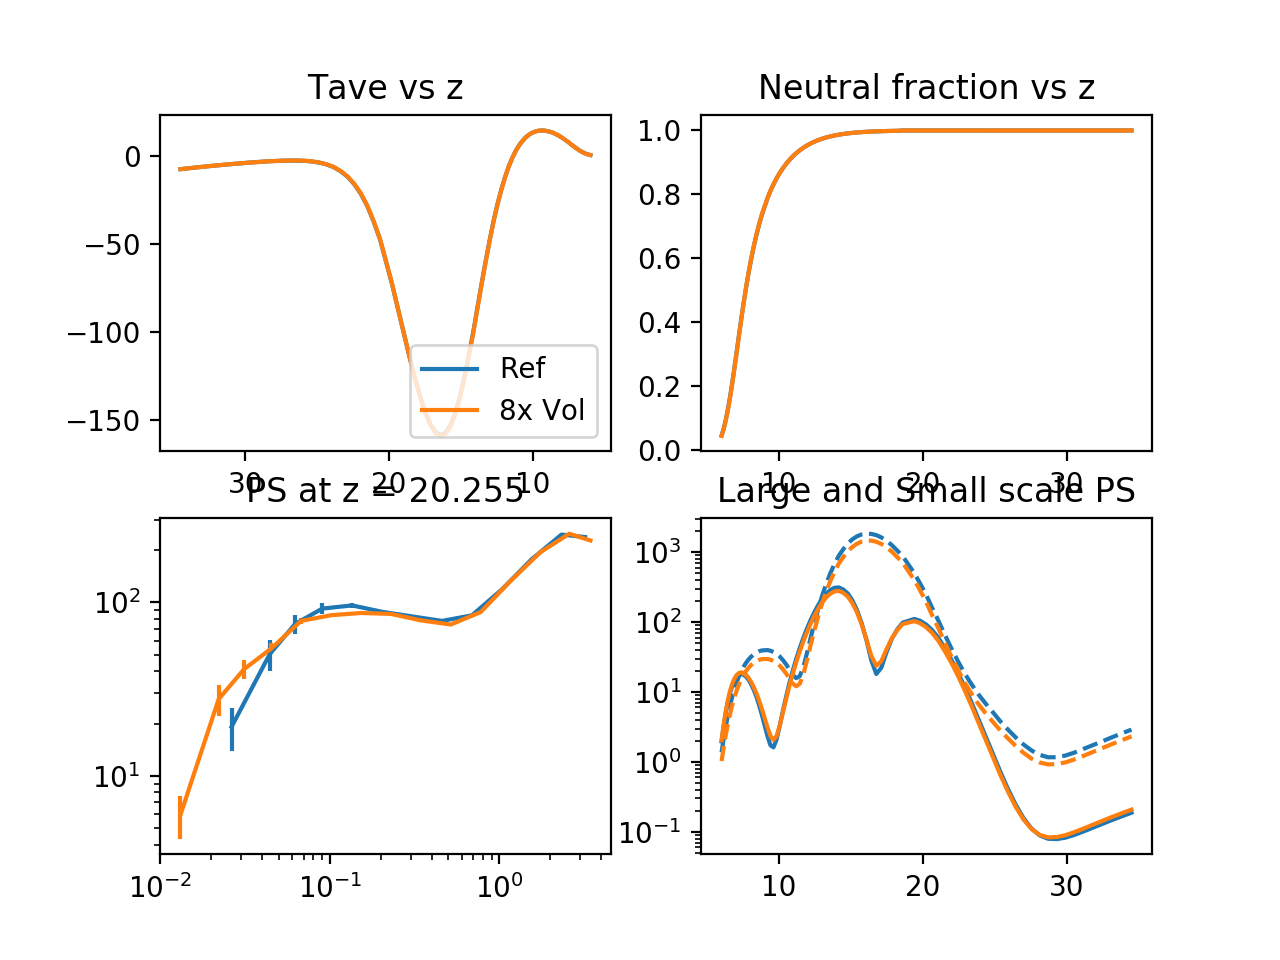

/home/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# First I'm going to compare the "out-of-box" run, and one with (2^3)x volume.
ref_PSglob = '/data4/beards/saved_21cmFAST_runs/Out-of-box_test/Deldel_T_power_spec_withTs/*'
PSglob = '/data4/beards/21cmFAST/Output_files/Deldel_T_power_spec/*'
tt.compare_runs([ref_PSglob, PSglob], labels=['Ref', '8x Vol'])

<IPython.core.display.Javascript object>


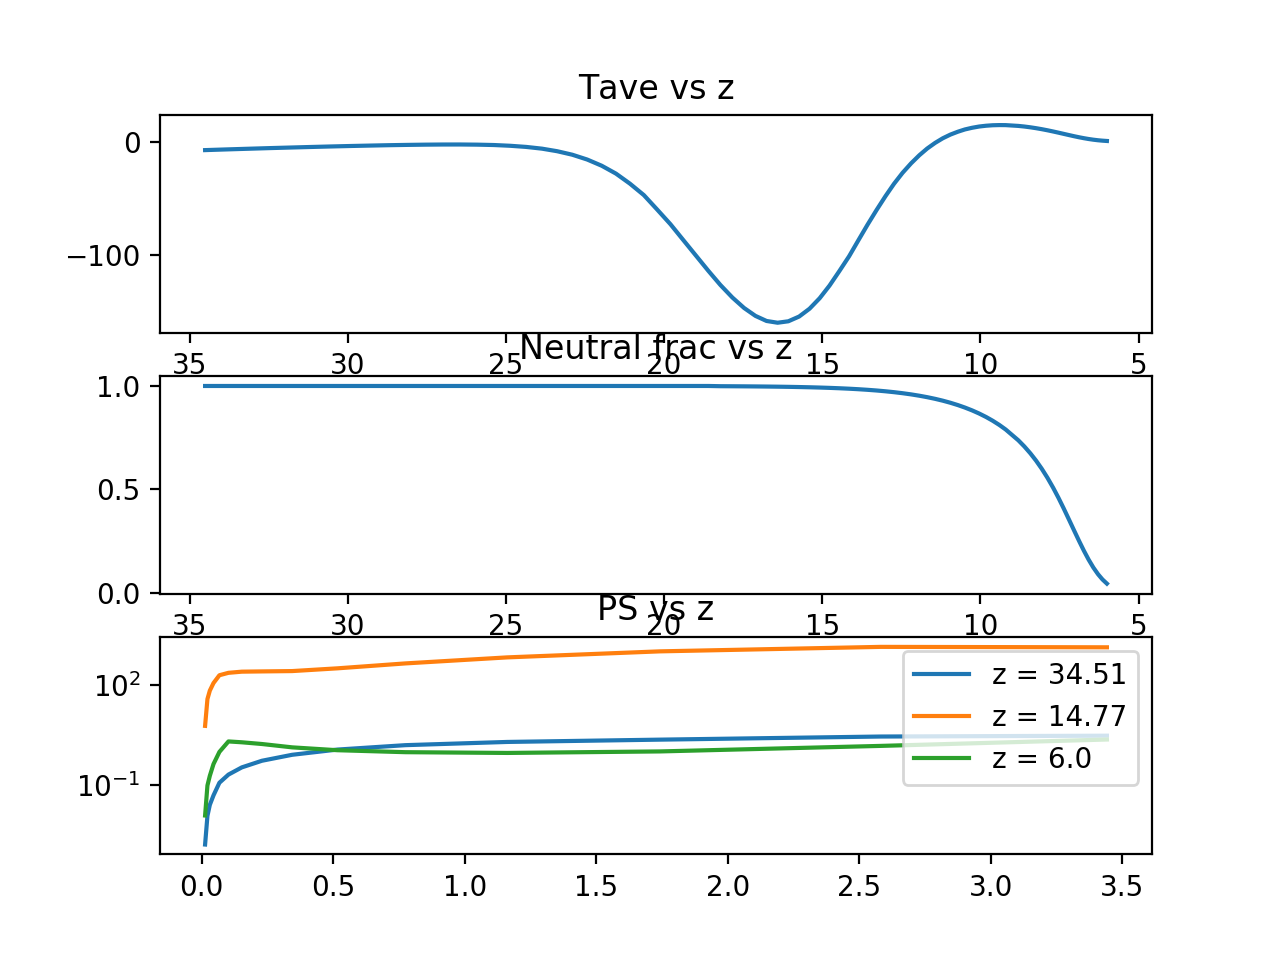

In [3]:
# Now focus on larger volume run
# Start by plotting some basics
parms, ks, delta2s, errs = tt.load_andre_models(PSglob)
nz = parms.shape[0]

plt.figure('Full run plots')
plt.subplot(311)
plt.plot(parms[:, 0], parms[:, 5])
plt.gca().invert_xaxis()
plt.title('Tave vs z')

plt.subplot(312)
plt.plot(parms[:, 0], parms[:, 1])
plt.gca().invert_xaxis()
plt.title('Neutral frac vs z')

plt.subplot(313)
plt.plot(ks[-1, :], delta2s[-1, :], label='z = ' + str(parms[-1, 0]))
plt.plot(ks[nz / 2, :], delta2s[nz / 2, :], label='z = ' + str(parms[nz / 2, 0]))
plt.plot(ks[0, :], delta2s[0, :], label='z = ' + str(parms[0, 0]))
plt.semilogy()
plt.title('PS vs z')
plt.legend()

plt.show()

In [4]:
def calc_FT_cube(incube, x, y, z, invert=False):
    """
    Function to FT cube and calculate k axes.
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        invert: Invert FT (go back to image space). Default False.
        
    Returns:
        FT_cube: 3D cube, the fourier transform of incube. No jacobian is applied.
        kx: 1D array of kx coordinates. Units Mpc^-1.
        ky: 1D array of ky coordinates. Units Mpc^-1.
        kz: 1D array of kz coordinates. Units Mpc^-1.
    """
    
    if invert:
        FT_cube = np.fft.ifftn(np.fft.ifftshift(incube))
    else:
        FT_cube = np.fft.fftshift(np.fft.fftn(incube))
    
    # Get k-axes
    dkx = 2 * np.pi / (x.max() - x.min())
    dky = 2 * np.pi / (y.max() - y.min())
    dkz = 2 * np.pi / (z.max() - z.min())
    kx = dkx * (np.arange(len(x)) - len(x) / 2)
    ky = dky * (np.arange(len(y)) - len(y) / 2)
    kz = dkz * (np.arange(len(z)) - len(z) / 2)
    
    return FT_cube, kx, ky, kz

In [5]:
def calc_PS_3d(incube, x, y, z):
    """
    Function to calculate 3D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        
    Returns:
        PS: 3D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        kx: 1D array of kx coordinates. Units Mpc^-1.
        ky: 1D array of ky coordinates. Units Mpc^-1.
        kz: 1D array of kz coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS, kx, ky, kz = calc_FT_cube(incube, x, y, z)
    jacobian = np.mean(np.diff(x)) * np.mean(np.diff(y)) * np.mean(np.diff(z))
    PS = np.abs(jacobian * PS)**2. / (x.max() - x.min()) / (y.max() - y.min()) / (z.max() - z.min())


    return PS, kx, ky, kz

In [6]:
def calc_PS_1d(incube, x, y, z, k_bin=1):
    """
    Function to calculate 1D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        k_bin: Factor by which to bin up k. Default 1.
        
    Returns:
        PS: 1D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        k: 1D array of k coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS_3d, kx, ky, kz = calc_PS_3d(incube, x, y, z)
    
    # Get k matrix 
    kxmat, kymat, kzmat = np.meshgrid(kx, ky, kz, indexing='ij')
    kmat = np.sqrt(kxmat**2 + kymat**2 + kzmat**2)
    
    # Form output axis
    dk = np.mean([np.mean(np.diff(kx)), np.mean(np.diff(ky)), np.mean(np.diff(kz))]) * k_bin
    k = np.arange(0, kmat.max(), dk)
    k_inds = np.digitize(kmat, k - 0.5 * dk)
    
    # Bin the PS
    PS = np.zeros(len(k))
    for i in range(len(k)):
        ind = np.where(k_inds == i)
        if len(ind[0]) == 0:
            continue
        PS[i - 1] = np.mean(PS_3d[ind])

    return PS, k

In [7]:
def calc_PS_2d(incube, x, y, z, kperp_bin=1, kpar_bin=1):
    """
    Function to calculate 2D power spectrum from an input cube
    
    Args:
        incube: 3D input cube in image space.
        x: 1D array of x-coordinates. Assumed to be in Mpc and evenly spaced.
        y: 1D array of y-coordinates. Assumed to be in Mpc and evenly spaced.
        z: 1D array of z-coordinates. Assumed to be in Mpc and evenly spaced.
        kperp_bin: Factor by which to bin up kperp. Default 1.
        kpar_bin: Factor by which to bin up kpar. Default 1.
        
    Returns:
        PS: 2D power spectrum. If inputcube is in mK, PS is in mK^2 Mpc^3
        kperp: 1D array of kperp coordinates. Units Mpc^-1.
        kpar: 1D array of kpar coordinates. Units Mpc^-1.
    """
    # Get 3D PS
    PS_3d, kx, ky, kz = calc_PS_3d(incube, x, y, z)
    
    # Get kperp matrix
    kxmat, kymat = np.meshgrid(kx, ky, indexing='ij')
    kperpmat = np.sqrt(kxmat**2 + kymat**2)
    
    # Form output axes
    dkperp = np.mean([np.mean(np.diff(kx)), np.mean(np.diff(ky))]) * kperp_bin
    kperp = np.arange(0, kperpmat.max(), dkperp)
    dkpar = np.mean(np.diff(kz)) * kpar_bin
    kz = np.abs(kz)  # Fold over
    kpar = np.arange(0, kz.max(), dkpar)
    kperpinds = np.digitize(kperpmat, kperp - 0.5 * dkperp)
    kparinds = np.digitize(kz, kpar - 0.5 * dkpar)
    kpar_ind_lookup = []
    for j in range(len(kpar)):
        ind_par = np.where(kparinds == j)[0]
        kpar_ind_lookup.append(ind_par)
    
    # Bin the PS
    PS = np.zeros((len(kperp), len(kpar)))
    for i in range(len(kperp)):
        ind_perp = np.where(kperpinds == i)
        if len(ind_perp[0]) == 0:
            continue
        for j in range(len(kpar)):
            ind_par = kpar_ind_lookup[j]
            if len(ind_par) == 0:
                continue
            PS[i - 1, j - 1] = np.mean(PS_3d[ind_perp][0, ind_par])

    return PS, kperp, kpar

In [10]:
def calc_xH_v_z(incube, ind=None, p=0.95):
    """
    Calculate the neutral fraction vs redshift of a cube.
    Also return the standard deviation of xH for each redshift.
    
    Args:
        incube: Neutral fraction cube. Assumed z is third dimension.
        ind: Indices to perp dimensions to include in calculation. Default is all.
        p: Percentage confidence interval in decimal. Default is 95%.

    Returns:
        xH: 1D array of neutral fraction per redshift.
        xH_conf: standard deviation of neutral fraction per redshift
    """
    
    if ind is None:
        ind = np.where(np.ones((incube.shape[0], incube.shape[1])))
    xH = np.median(incube[ind], axis=0)
    xH_conf = np.percentile(incube[ind], [100 * (1 - p) / 2., 100 * (1 + p) / 2.], axis=0)
    return xH, xH_conf

In [8]:
def hera_layout(nrings=10, dither=True, outriggers=False):
    """
    Create antenna positions for hex with given number of rings
    
    Args:
        rings: number of rings to make up array.
        dither: Whether to dither the core.
        
    Returns:
        ant_locs: 2D array of antenna locations in meters.
    """
    ndish = np.sum(np.arange(nrings + 1) * 6) + 1
    if outriggers:
        ndish += 12 + 18
    locs = np.zeros((ndish, 2))
    dE = 14.61
    dN = dE * np.cos(np.pi / 6)
    
    ant = 1
    for ring in (np.arange(nrings) + 1):
        curE = -ring * dE
        curN = 0
        locs[ant, :] = [curE, curN]
        locs[ant + 1, :] = [-curE, curN]
        ant += 2
        for row in range(ring):
            curE += 0.5 * dE
            curN += dN
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [curE, -curN]
            locs[ant + 2, :] = [-curE, curN]
            locs[ant + 3, :] = [-curE, -curN]
            ant += 4
        for col in range(ring-1):
            curE += dE
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [curE, -curN]
            ant += 2
    
    if outriggers:
        for ring in (np.arange(2) + 2):
            curE = -ring * nrings * dE
            curN = 0
            locs[ant, :] = [curE, curN]
            locs[ant + 1, :] = [-curE, curN]
            ant += 2
            for row in range(ring):
                curE += 0.5 * nrings * dE
                curN += nrings * dN
                locs[ant, :] = [curE, curN]
                locs[ant + 1, :] = [curE, -curN]
                locs[ant + 2, :] = [-curE, curN]
                locs[ant + 3, :] = [-curE, -curN]
                ant += 4
            for col in range(ring-1):
                curE += nrings * dE
                locs[ant, :] = [curE, curN]
                locs[ant + 1, :] = [curE, -curN]
                ant += 2
    
    if dither:
        ind = np.where((locs[:, 1] > 0) & (locs[:, 1] > np.tan(np.deg2rad(60)) * locs[:, 0]))[0]
        locs[ind, :] += np.array([-0.5 * dE, dN / 3.])
        ind = np.where((locs[:, 0] > 0) & (locs[:, 1] < np.tan(np.deg2rad(60)) * locs[:, 0]) &
                       (locs[:, 1] > -np.tan(np.deg2rad(60)) * locs[:, 0]))
        locs[ind, :] += np.array([0, 2. * dN / 3.])

    return locs

In [12]:
def get_noise(FT_cube, noise_PS, jacobian, seed=None):
    """
    Get realization of random noise for a measurement cube.
    
    Args:
        FT_cube: 3D cube, in Fourier space to add noise to. (e.g. output of calc_FT_cube)
        noise_PS: 2D or 3D array of noise PS. If 2D assumes matches perp dims of FT_cube
                   and uniform in par. If 3D assumes matches all dims of FT_cube.
        jacobian: The jacobian factor used in the PS calculation. e.g. dx*dy*dz
        seed: random number seed (useful for repeatability)
    """
    np.random.seed(seed)
    Nfact = FT_cube.size
    noise_PS = np.where(np.isinf(noise_PS), 0, noise_PS)
    if len(noise_mat.shape) == 2:
        noise_PS = noise_PS[:, :, np.newaxis]
    noise = np.random.normal(size=FT_cube.shape) + 1j * np.random.normal(size=FT_cube.shape)
    noise *= np.sqrt(noise_PS * Nfact / (2. * jacobian))  # 2 for complex
    return noise

In [13]:
outdir = '/data4/beards/local_reion_sandbox/'
plotdir = outdir + 'plots/'

In [14]:
# Create an observation cube
run = 'big_vol'
if run == 'out-of-box':
    box_glob = '/data4/beards/saved_21cmFAST_runs/Out-of-box_test/Boxes_withTs/*'
    raw_cube_file = outdir + 'raw_cube_256_300Mpc.npz'
    xH_file = outdir + 'xH_cube_256_300Mpc.npz'
    xH_cone_file = outdir + 'xH_cone_256_300Mpc.npz'
elif run == 'big_vol':
    box_glob = '/data4/beards/21cmFAST/Boxes/*'
    raw_cube_file = outdir + 'raw_cube_512_600Mpc.npz'
    xH_file = outdir + 'xH_cube_512_600Mpc.npz'
    xH_cone_file = outdir + 'xH_cone_512_600Mpc.npz'
else:
    raise ValueError('run not recognized')
if os.path.exists(raw_cube_file):
    d = np.load(raw_cube_file)
    band = d['band']
    bandz = 1420.0 / band - 1
    raw_cube = d['raw_cube']
    xaxis = d['xaxis']
    yaxis = d['yaxis']
    zaxis = d['zaxis']
else:
    band = np.arange(100, 200, .1)
    bandz = 1420.0 / band - 1
    raw_cube = tt.build_light_cone(box_glob, zs=bandz)
    eg_file = glob.glob(box_glob)[0].split('_')
    xaxis = np.linspace(start=0, stop=float(eg_file[-1][:-3]),
                        num=float(eg_file[-2]))
    yaxis = xaxis
    zaxis = cosmo.comoving_distance(bandz).value
    np.savez(raw_cube_file, band=band, raw_cube=raw_cube, xaxis=xaxis,
             yaxis=yaxis, zaxis=zaxis)

In [15]:
# Get a nf cube for a single observation slice
# Note this cube will match coordinates of raw_cube, but rather
# than a lightcone, it is a fixed slice of space (single distance LoS),
# with the full history of that location.
z0 = 7.7  # Redshift to fix distance LoS. 
if os.path.exists(xH_file):
    d = np.load(xH_file)
    xH_cube = d['xH_cube']
else:
    xH_cube = tt.build_history_cube(box_glob, z0=z0, zs=bandz, boxtype='xH')
    np.savez(xH_file, xH_cube=xH_cube)

In [16]:
# Make a nf lightcone cube
if os.path.exists(xH_cone_file):
    d = np.load(xH_cone_file)
    xH_cone = d['xH_cone']
else:
    xH_cone = tt.build_light_cone(box_glob, zs=bandz, boxtype='xH')
    np.savez(xH_cone_file, xH_cone=xH_cone)

<IPython.core.display.Javascript object>


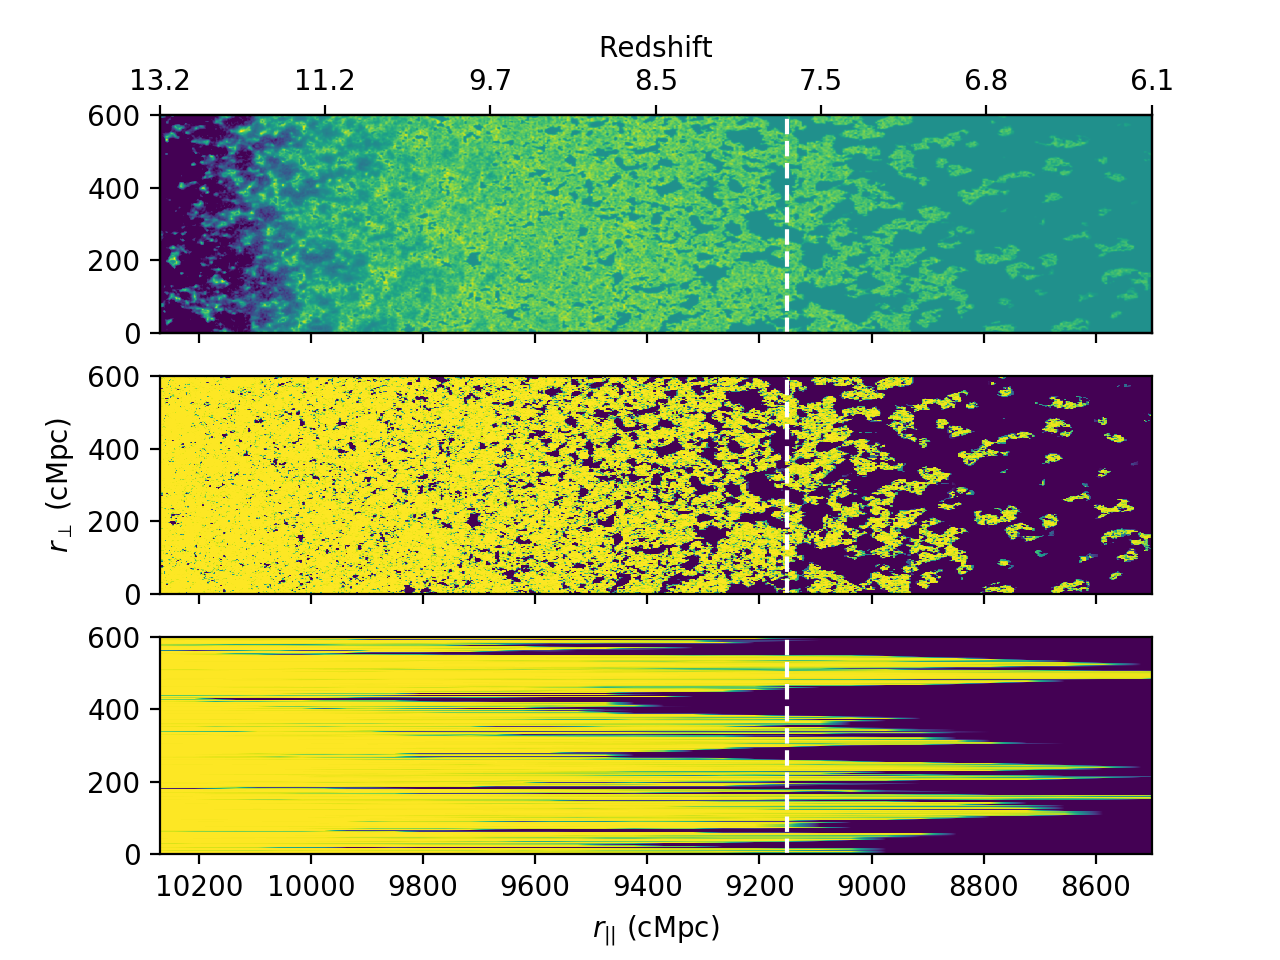

In [17]:
# Plot delta-T cube and neutral fraction
f, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)
ax[0].imshow(raw_cube[raw_cube.shape[0] / 2, :, :], interpolation='bicubic',
             extent=[zaxis[0], zaxis[-1], xaxis[0], xaxis[-1]], aspect='auto',
             vmin=-0.6 * raw_cube.max(), vmax=0.6 * raw_cube.max())
# zaxis is not quite linear, need to account for that.
ind = np.argmin(np.abs(bandz - z0))
z_match = ind * (zaxis[-1] - zaxis[0]) / len(zaxis) + zaxis[0]
ax[0].plot([z_match, z_match], [xaxis[0], xaxis[-1]], '--w')
axtop = ax[0].twiny()
axtop.set_xlim(0, len(bandz))
axtop.set_xticks(np.linspace(0, len(bandz), 7, dtype=int))
axtop.set_xticklabels(["%.1f" % z for z in bandz[np.linspace(0, len(bandz) - 1, 7, dtype=int)]])
axtop.set_xlabel('Redshift')
#ax[0].set_xticklabels([])

ax[1].imshow(xH_cone[xH_cone.shape[0] / 2, :, :], interpolation='none',
             extent=[zaxis[0], zaxis[-1], xaxis[0], xaxis[-1]], aspect='auto')
ax[1].plot([z_match, z_match], [xaxis[0], xaxis[-1]], '--w')
ax[2].imshow(xH_cube[xH_cube.shape[0] / 2, :, :], interpolation='none',
             extent=[zaxis[0], zaxis[-1], xaxis[0], xaxis[-1]], aspect='auto')
ax[2].plot([z_match, z_match], [xaxis[0], xaxis[-1]], '--w')
plt.show()
ax[2].set_xlabel('$r_{||}$ (cMpc)')
ax[1].set_ylabel('$r_{\perp}$ (cMpc)')
plt.savefig(plotdir + 'raw_history.pdf')
plt.show()

In [18]:
# Do some preliminary neutral fraction calculations
xH_all, xH_all_conf = calc_xH_v_z(xH_cube, p=.68)
ind_xHI = np.where(xH_cube[:, :, ind] > 0.5)
xH_neutral, xH_neutral_conf = calc_xH_v_z(xH_cube, ind=ind_xHI, p=0.68)
ind_xHII = np.where(xH_cube[:, :, ind] < 0.02)
xH_ionized, xH_ionized_conf = calc_xH_v_z(xH_cube, ind=ind_xHII, p=0.68)

<IPython.core.display.Javascript object>


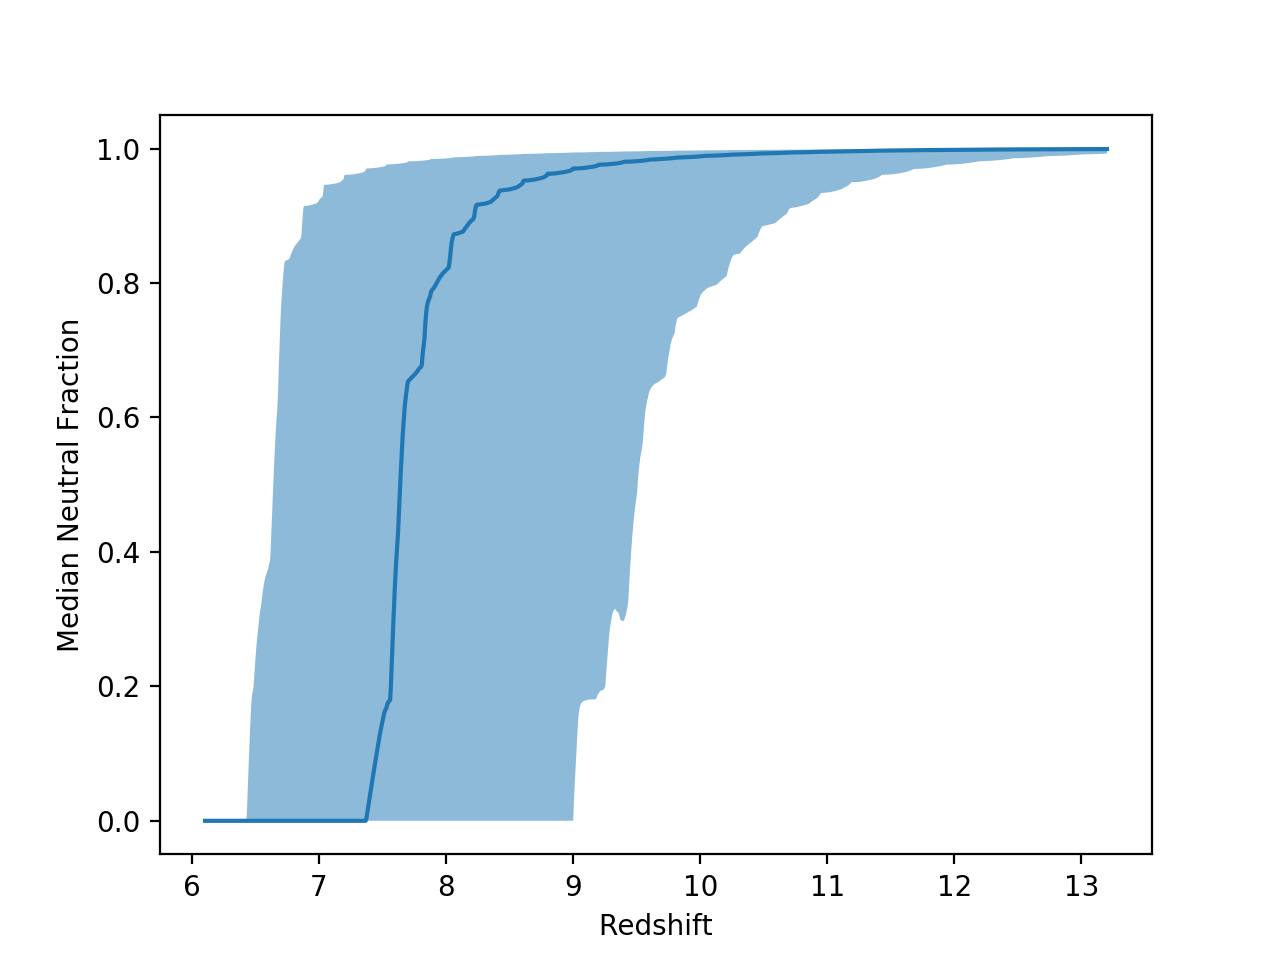

In [19]:
# Plot
plt.figure()
plt.plot(bandz, xH_all, label='All')
plt.fill_between(bandz, xH_all_conf[0, :], xH_all_conf[1, :], alpha=0.5)
plt.xlabel('Redshift')
plt.ylabel('Median Neutral Fraction')
plt.savefig(plotdir + 'raw_nf.pdf')
plt.show()

<IPython.core.display.Javascript object>


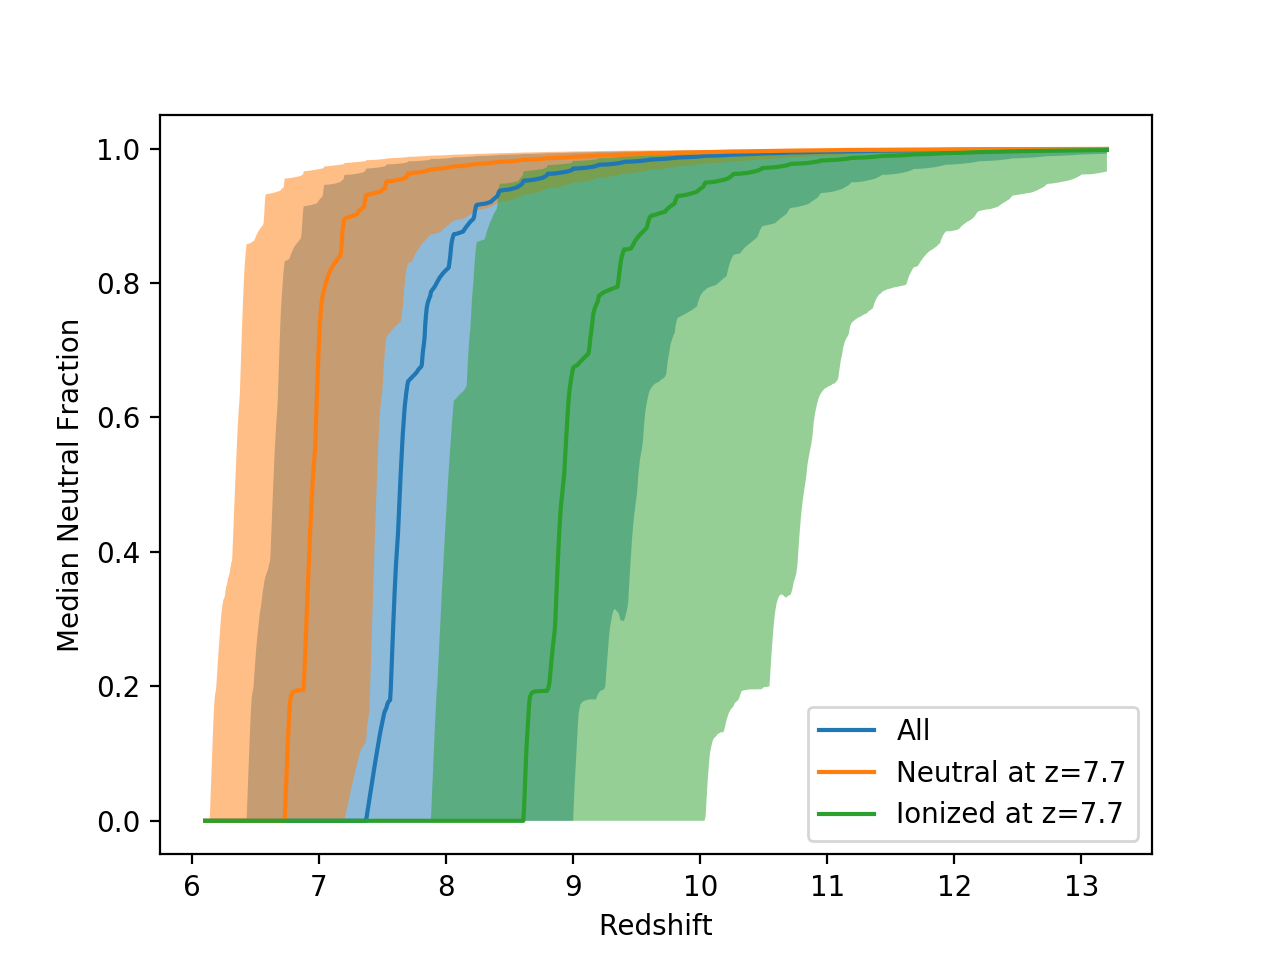

In [20]:
# plot
plt.figure()
plt.plot(bandz, xH_all, label='All')
plt.fill_between(bandz, xH_all_conf[0, :], xH_all_conf[1, :], alpha=0.5)
plt.plot(bandz, xH_neutral, label='Neutral at z=' + str(z0))
plt.fill_between(bandz, xH_neutral_conf[0, :], xH_neutral_conf[1, :], alpha=0.5)
plt.plot(bandz, xH_ionized, label='Ionized at z=' + str(z0))
plt.fill_between(bandz, xH_ionized_conf[0, :], xH_ionized_conf[1, :], alpha=0.5)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Median Neutral Fraction')
plt.savefig(plotdir + 'raw_nf_groups.pdf')
plt.show()

In [21]:
# Angular size of transverse section
print('angular extent = ' + str(np.rad2deg(xaxis[-1] / zaxis[500])) + ' deg')
print('angular resolution = ' + str(np.rad2deg((xaxis[1] - xaxis[0]) / zaxis[500]) * 60) + ' arcmin')

angular extent = 3.693320227286041 deg
angular resolution = 0.4336579523232142 arcmin


In [23]:
# Smooth and downsample cube in transverse direction
umax = 600  # meters
fov = np.deg2rad(10)
dx = xaxis[1] - xaxis[0]
dy = yaxis[1] - yaxis[0]
conv_cube = np.zeros_like(raw_cube)
sig = zaxis * const.c.to('m/s').value / (band * 1e6 * umax) / 2.
minsig = int(0.85 * np.round(sig.min()))  # keep a little extra resolution
downlen = (len(np.arange(0, raw_cube.shape[0], minsig)), len(np.arange(0, raw_cube.shape[1], minsig)))
downselect_cube = np.zeros((downlen[0], downlen[1], raw_cube.shape[2]))
for i in range(raw_cube.shape[-1]):
    conv_cube[:, :, i] = filters.gaussian_filter(raw_cube[:, :, i], [sig[i] / dx, sig[i] / dy], mode='wrap')
    downselect_cube[:, :, i] = conv_cube[::minsig, ::minsig, i]
pads = ((0, int(np.ceil(fov * np.max(zaxis) / (dx * minsig))) - downselect_cube.shape[0]),
        (0, int(np.ceil(fov * np.max(zaxis) / (dy * minsig))) - downselect_cube.shape[1]),
        (0, 0))
tiled_cube = np.pad(downselect_cube, pads, mode='wrap')
x_tiled = np.arange(tiled_cube.shape[0]) * dx * minsig
xmap = np.pad(np.arange(0, len(xaxis), minsig), pads[0], mode='wrap')

In [24]:
xH_tiled = xH_cone[::minsig, ::minsig, :]
xH_tiled = np.pad(xH_tiled, pads, mode='wrap')

<IPython.core.display.Javascript object>


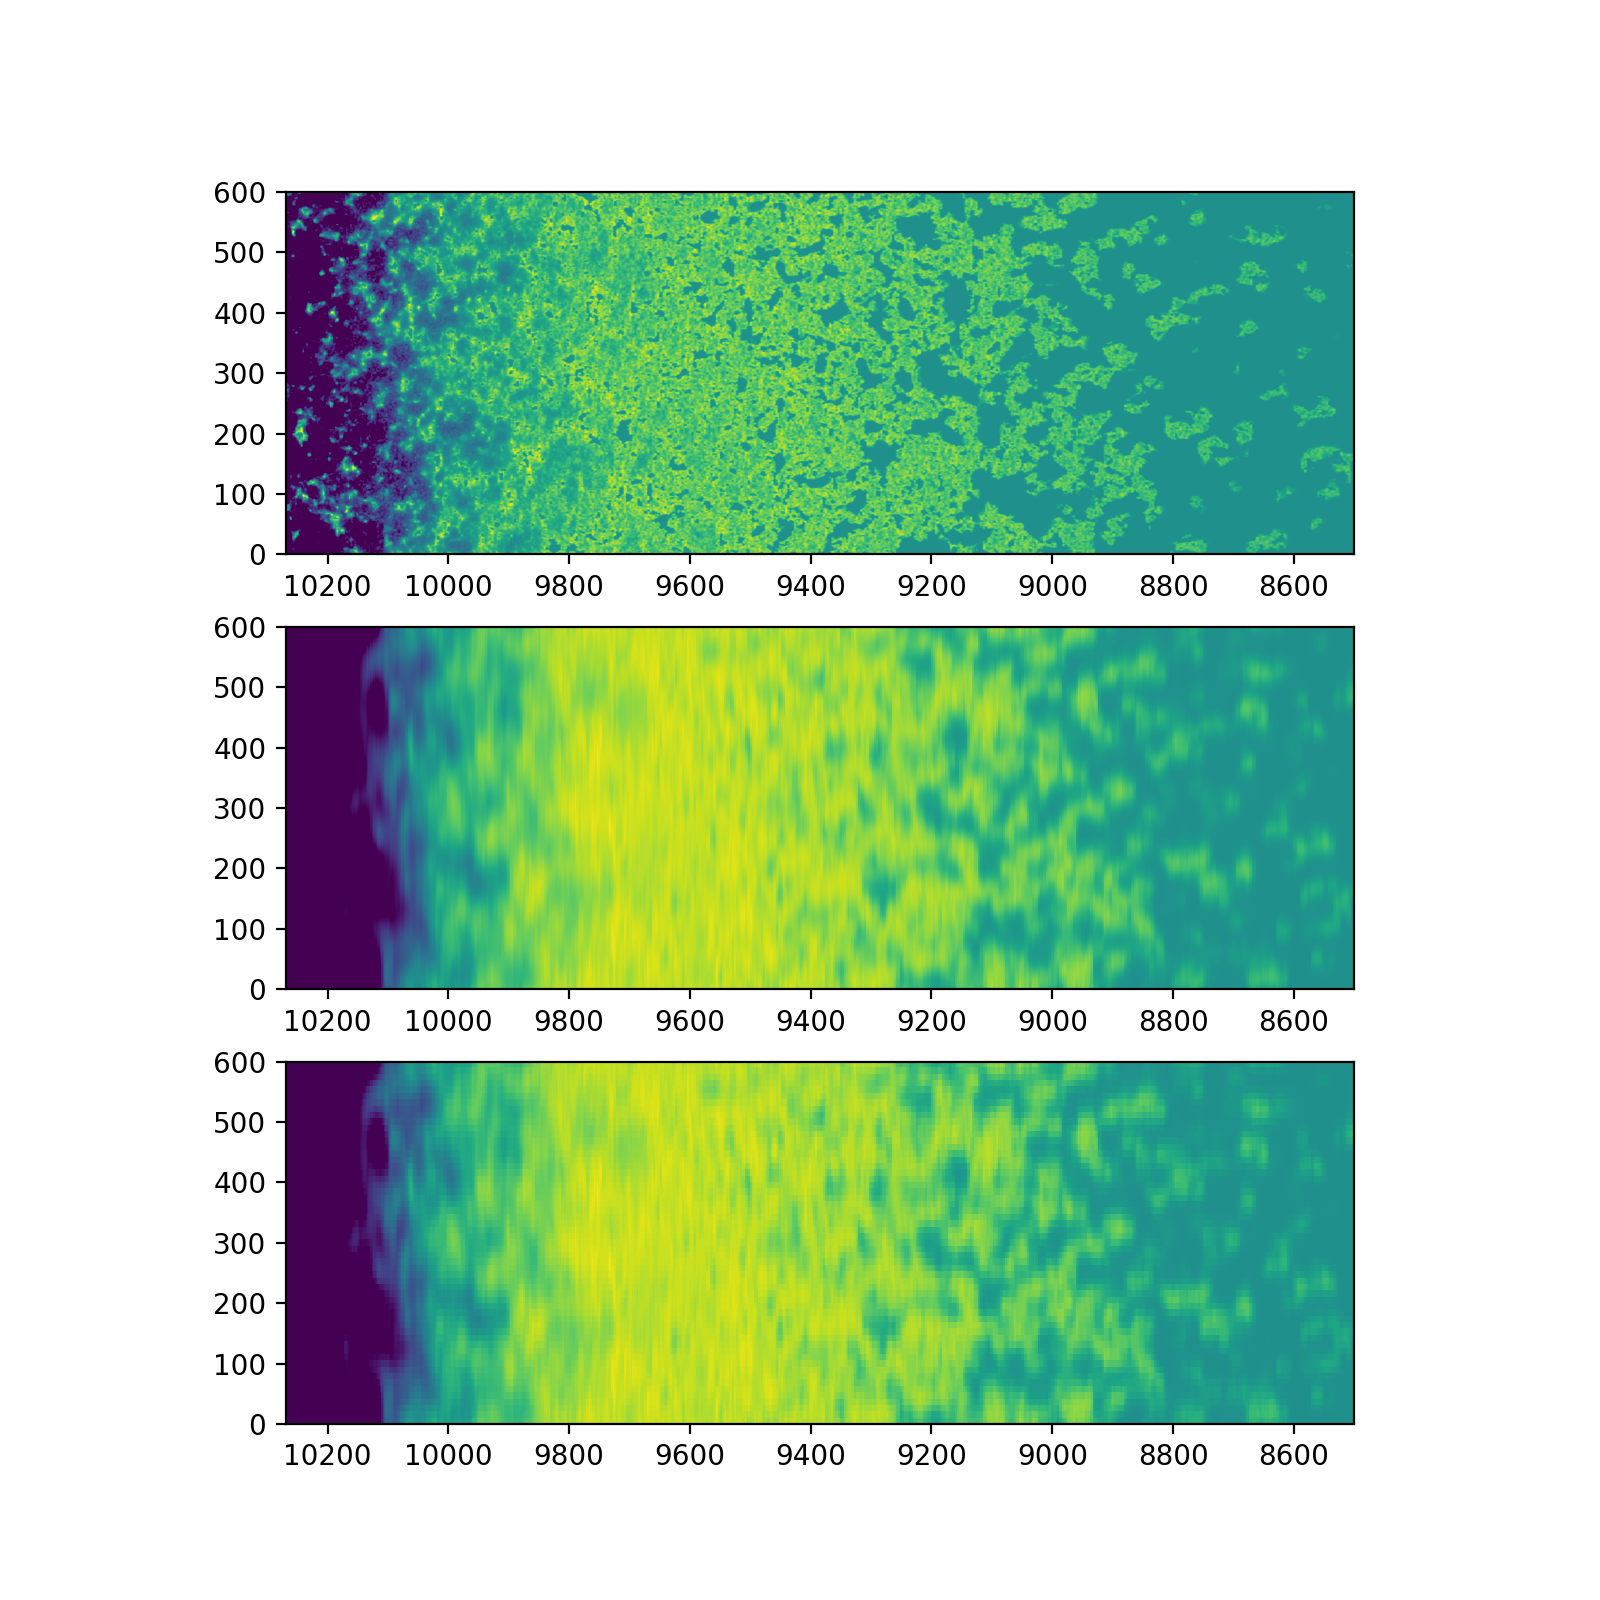

In [25]:
# Plot smoothed and downselected versions
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(311)
plt.subplot(311)
plt.imshow(raw_cube[raw_cube.shape[0] / 2, :, :], interpolation='bicubic',
                 extent=[zaxis[0], zaxis[-1], xaxis[0], xaxis[-1]])
plt.clim([-raw_cube.max() * .6, raw_cube.max() * .6])
ax2 = plt.subplot(312, sharex=ax1, sharey=ax1)
plt.imshow(conv_cube[conv_cube.shape[0] / 2, :, :], interpolation='none',
           extent=[zaxis[0], zaxis[-1], xaxis[0], xaxis[-1]])
plt.clim([-conv_cube.max(), conv_cube.max()])
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.imshow(downselect_cube[downselect_cube.shape[0] / 2, :, :], interpolation='none',
           extent=[zaxis[0], zaxis[-1], xaxis[0], xaxis[-1]])
plt.clim([-conv_cube.max(), conv_cube.max()])

<IPython.core.display.Javascript object>


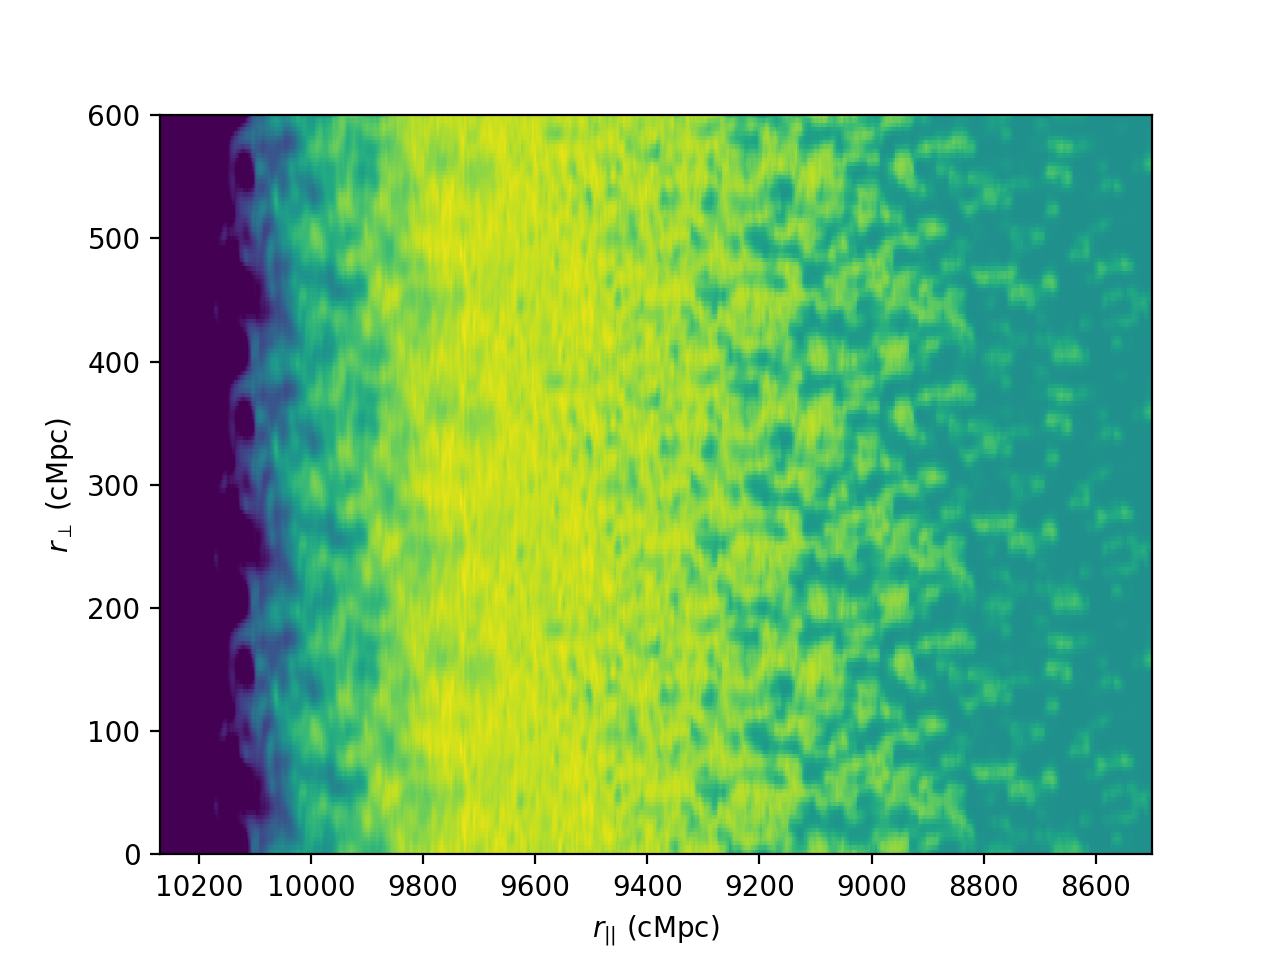

In [26]:
# And the tiled version
plt.figure()
plt.imshow(tiled_cube[tiled_cube.shape[0] // 2, :, :], aspect='auto', interpolation='none',
           extent=[zaxis[0], zaxis[-1], xaxis[0], xaxis[-1]])
plt.clim([-tiled_cube.max(), tiled_cube.max()])
plt.xlabel('$r_{||}$ (cMpc)')
plt.ylabel('$r_{\perp}$ (cMpc)')
plt.savefig(plotdir + 'tiled_cube.pdf')
plt.show()

In [ ]:
# FT slices of data
slice_width = 60  # Number of freq bins
nslices = int(np.floor(len(zaxis) / float(slice_width)))
PS_slices = []
FT_groups = []
k_slices = []

for i in range(nslices):
    PS, k = calc_PS_1d(raw_cube[:, :, (slice_width * i):(slice_width * (i + 1))],
                       xaxis, yaxis, zaxis[(slice_width * i):(slice_width * (i + 1))], k_bin=10)
    PS_slices.append(PS)
    k_slices.append(k)
    FT_groups.append(calc_FT_cube(tiled_cube[:, :, (slice_width * i):(slice_width * (i + 1))],
                                  x_tiled, x_tiled, zaxis[(slice_width * i):(slice_width * (i + 1))]))

# Unpack FT and axes
FT_slices = [group[0] for group in FT_groups]
kx_slices = [group[1] for group in FT_groups]
ky_slices = [group[2] for group in FT_groups]
kz_slices = [group[3] for group in FT_groups]
del(FT_groups)

<IPython.core.display.Javascript object>


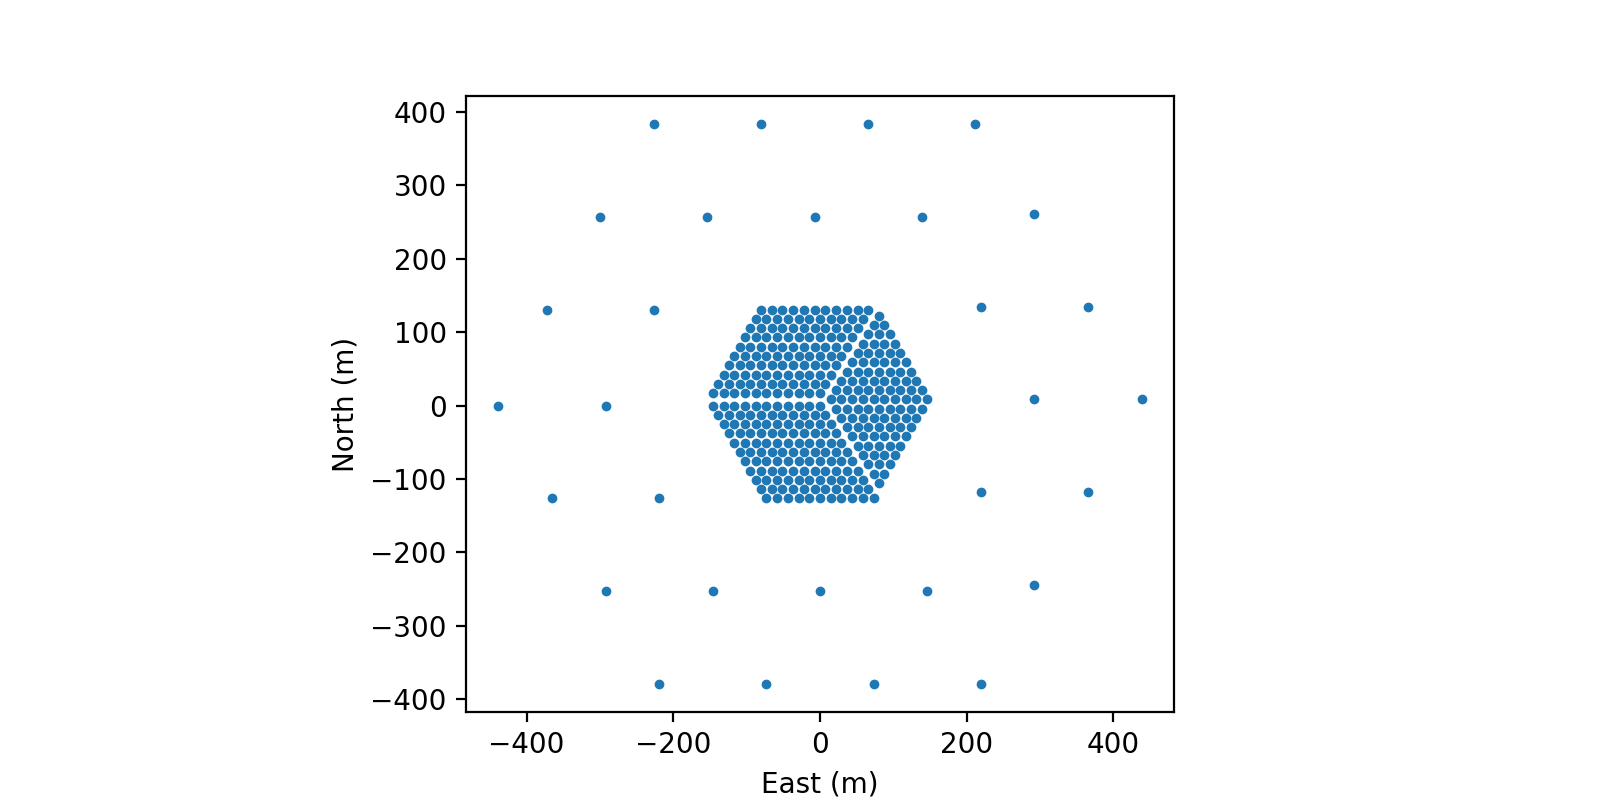

In [25]:
# plot
antpos = hera_layout(outriggers=True)
plt.figure(figsize=(8, 4))
plt.plot(antpos[:, 0], antpos[:, 1], 'o', ms=2.5)
plt.axes().set_aspect('equal')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.savefig(plotdir + 'hera_layout.pdf')
plt.show()

<IPython.core.display.Javascript object>


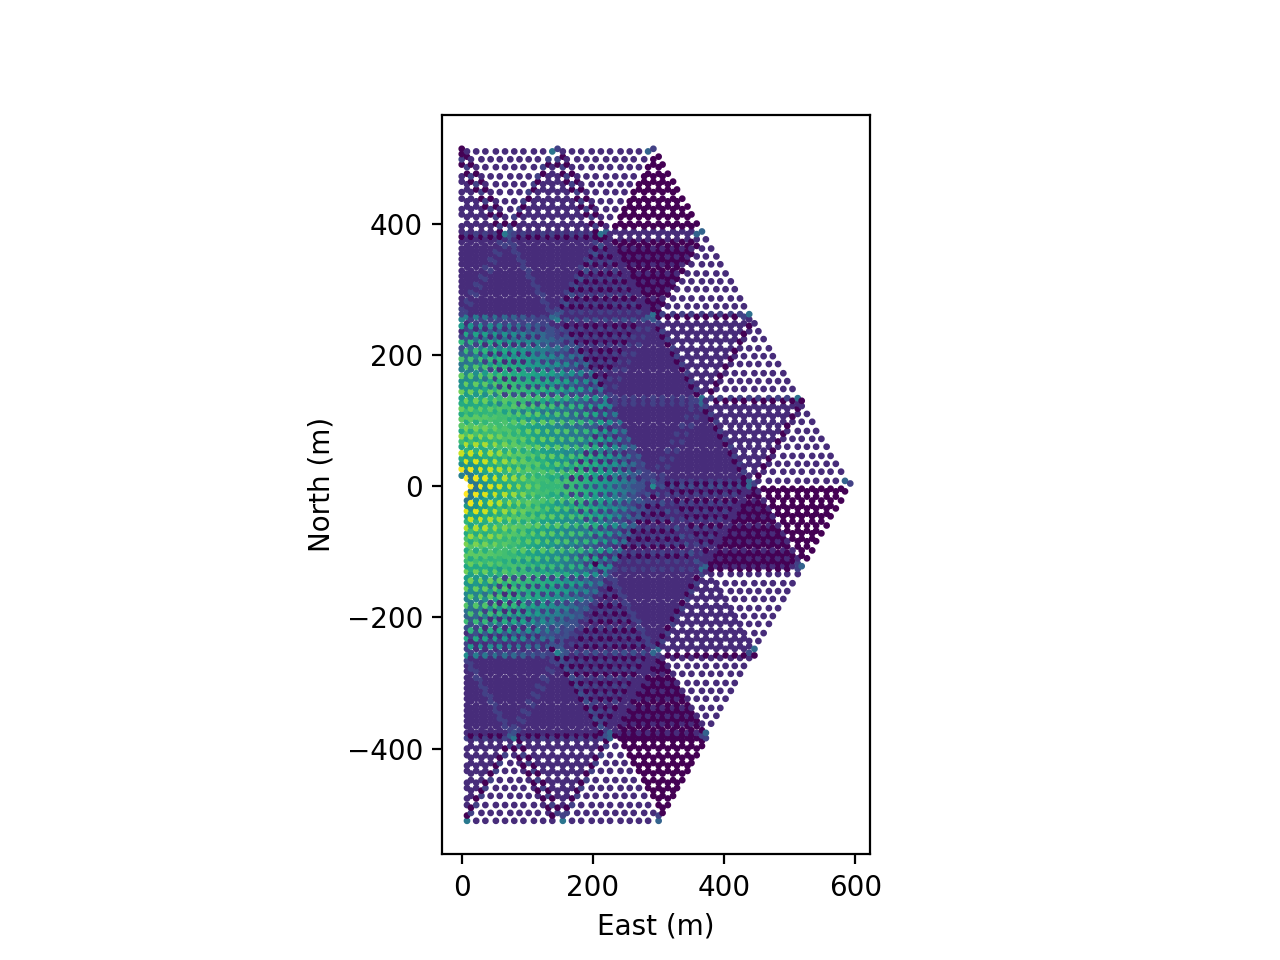

In [27]:
# baselines
bls = []
unique_tol = 2.
for i in range(antpos.shape[0]):
    for j in range(i + 1, antpos.shape[0]):
        bl = antpos[i, :] - antpos[j, :]
        if bl[0] >= -1:
            if (bl[0] < 1) and (bl[1] < 0):
                bls.append(-bl)
            else:
                bls.append(bl)
        else:
            bls.append(-bl)
bls = np.array(bls)
bls = bls[np.linalg.norm(bls, axis=1) <= umax]
bls = np.round(bls / unique_tol)
bls, bl_counts = np.unique(bls, axis=0, return_counts=True)
bls = bls * unique_tol
plt.figure()
plt.scatter(bls[:, 0], bls[:, 1], c=np.log(bl_counts), s=2)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.axes().set_aspect('equal')
plt.savefig(plotdir + 'hera_baselines.pdf')

In [28]:
# Noise estimate
noise_mats = []
redshifts = []
ndays = 225.
time_length = 32. * 60.  # seconds
dt = 5. * 60.  # seconds
time_range = np.arange(-time_length / 2, time_length / 2, dt)
# Some geo to trim down code later
latitude = -0.53619181  # rad
dec = latitude  # zen drift
sdec = np.sin(dec)
cdec = np.cos(dec)
slat = np.sin(latitude)
clat = np.cos(latitude)

for i in range(nslices):
    redshifts.append(bandz[slice_width * i:slice_width * (i + 1)].mean())
    B = (band[slice_width * (i + 1) - 1] - band[slice_width * i]) * 1e6  # Hz
    f0 = np.mean(band[slice_width * i:slice_width * (i + 1)])  # MHz
    lambdas = const.c.to('m/s').value / (band[slice_width * i:slice_width * (i + 1)] * 1e6)  # m
    lambda0 = lambdas.mean()
    D = zaxis[slice_width * i:slice_width * (i + 1)].mean()  # Mpc
    deltaD = zaxis[slice_width * i] - zaxis[slice_width * (i + 1) - 1]  # Mpc
    Aeff = 93.  # m^2 (Neben et al 2016)
    Tsys = (180. * (180. / f0)**2.55 + 100.) * 1e3  # mK
    factor = Tsys**2 * (D**2 * lambda0**2 / Aeff) * (deltaD / B)  # Beardsley et al 2013 (eq 2)

    mat = np.zeros(FT_slices[i].shape[0:2])
    b2k = 2 * np.pi / zaxis[slice_width * i:slice_width * (i + 1)] / lambdas
    dkx = np.mean(np.diff(kx_slices[i]))
    dky = np.mean(np.diff(ky_slices[i]))
    for t in time_range:
        theta = t * np.pi / (12. * 3600.)
        # do rotation
        u_m = bls[:, 0] * np.cos(theta) - bls[:, 1] * slat * np.sin(theta)
        v_m = bls[:, 0] * sdec * np.sin(theta) + bls[:, 1] * (sdec * np.cos(theta) * slat + cdec * clat)
        for fi in range(slice_width):
            # scale u
            u = u_m * b2k[fi]
            v = v_m * b2k[fi]
            # bin
            ind = (map(int, np.round(u / dkx) - mat.shape[0] // 2),
                   map(int, np.round(v / dky) - mat.shape[1] // 2))
            mat[ind] += bl_counts * dt * ndays
    matN = np.divide(factor, mat, where=mat > .5 * dt)
    matN = np.where(mat > .5 * dt, matN, np.inf)
    noise_mats.append(matN * slice_width)  # should be average over freq, not sum

<IPython.core.display.Javascript object>


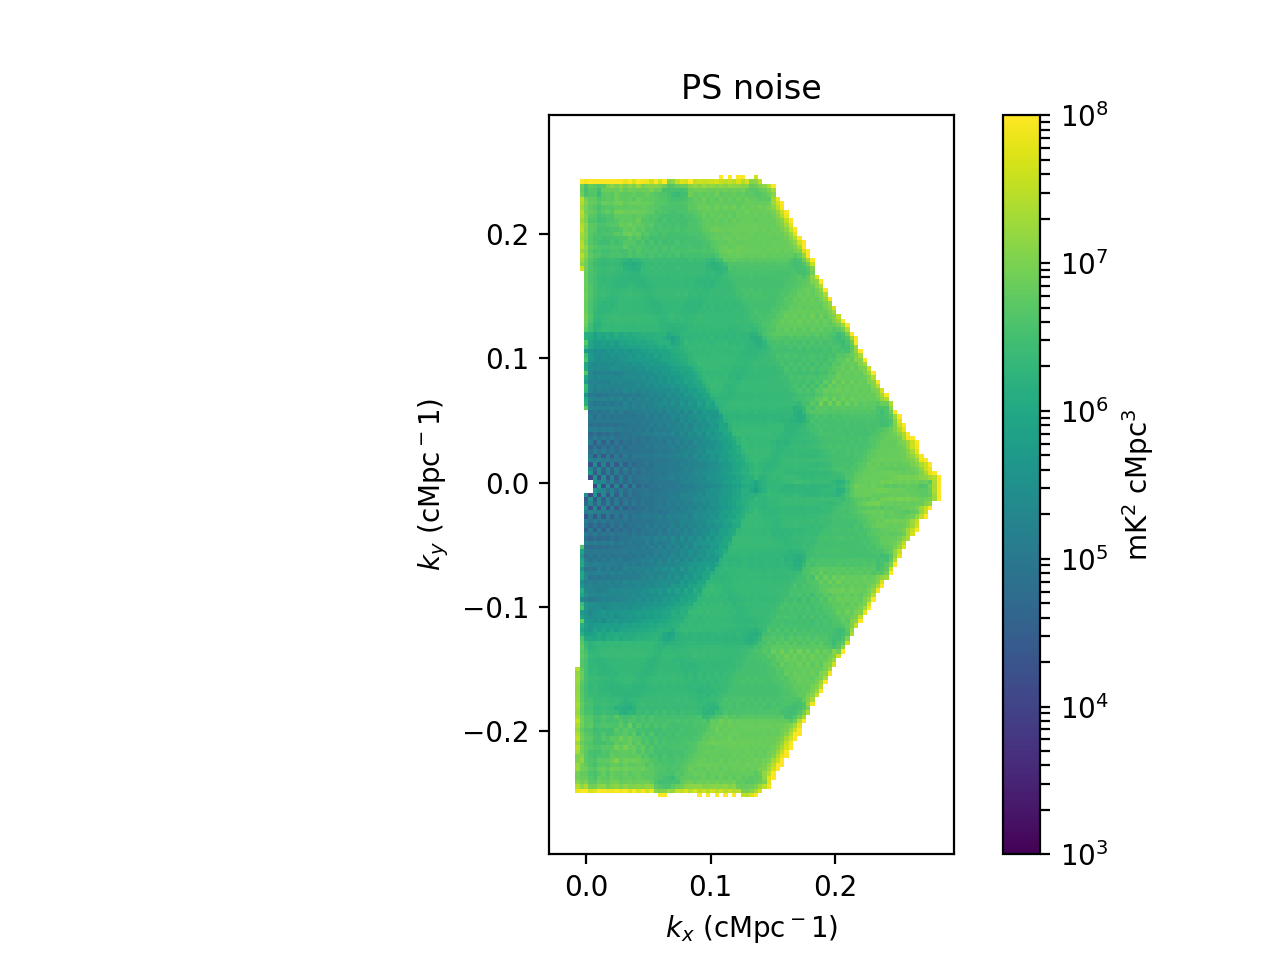

In [29]:
# plot
plt.figure()
plt.imshow(noise_mats[-1].T, norm=LogNorm(), vmin=1e3, vmax=1e8,
           extent=[kx_slices[0].min(), kx_slices[0].max(),
                   ky_slices[0].min(), ky_slices[0].max()])
plt.colorbar(label='mK$^2$ cMpc$^3$')
plt.xlim([0.1 * kx_slices[0].min(), kx_slices[0].max()])
plt.xlabel('$k_x$ (cMpc$^-1$)')
plt.ylabel('$k_y$ (cMpc$^-1$)')
plt.title('PS noise')
plt.savefig(plotdir + 'PS_noise.pdf')
plt.show()

In [30]:
# PS interp slices
PS_interp_slices = []
kperp_mat_slices = []
kz_mat_slices = []
kmat_slices = []
for i in range(nslices):
    kxmat, kymat, kzmat = np.meshgrid(kx_slices[i], ky_slices[i], kz_slices[i], indexing='ij')
    kperp_mat_slices.append(np.sqrt(kxmat**2 + kymat**2))
    kz_mat_slices.append(kzmat)
    kmat = np.sqrt(kxmat**2 + kymat**2 + kzmat**2)
    f = interp1d(k_slices[i], PS_slices[i])
    PS_interp_slices.append(f(kmat))

In [31]:
# Apply Wiener filter and FG mask
wedge_mode = 'fov'
if wedge_mode == 'full_sky':
    wedge_angle = np.pi / 2.
elif wedge_mode == 'half_sky':
    wedge_angle = np.pi / 4.
elif wedge_mode == 'half_sky_long_int':
    wedge_angle = np.pi / 4.
elif wedge_mode == 'twice_fov':
    wedge_angle = fov
elif wedge_mode == 'fov':
    wedge_angle = fov / 2.
elif wedge_mode == 'none':
    wedge_angle = 0
kz_buffer = 0
kperp_buffer = 0
kfilters = []

for i in range(nslices):
    wedge_slope = (wedge_angle * cosmo.comoving_distance(redshifts[0]).value /
                   cosmo.hubble_distance.value * cosmo.efunc(redshifts[0]) / (1 + redshifts[0]))
    fil = PS_interp_slices[i] / (PS_interp_slices[i] + noise_mats[i].reshape(noise_mats[i].shape + (1,)))
#     fil = np.ones_like(FT_slices[i], dtype=np.float)
    fil[kperp_mat_slices[i] <= kperp_buffer] = 0
    fil[np.abs(kz_mat_slices[i]) <= kz_buffer] = 0
    fil[np.abs(kz_mat_slices[i]) < wedge_slope * kperp_mat_slices[i]] = 0
    kfilters.append(fil)

<IPython.core.display.Javascript object>


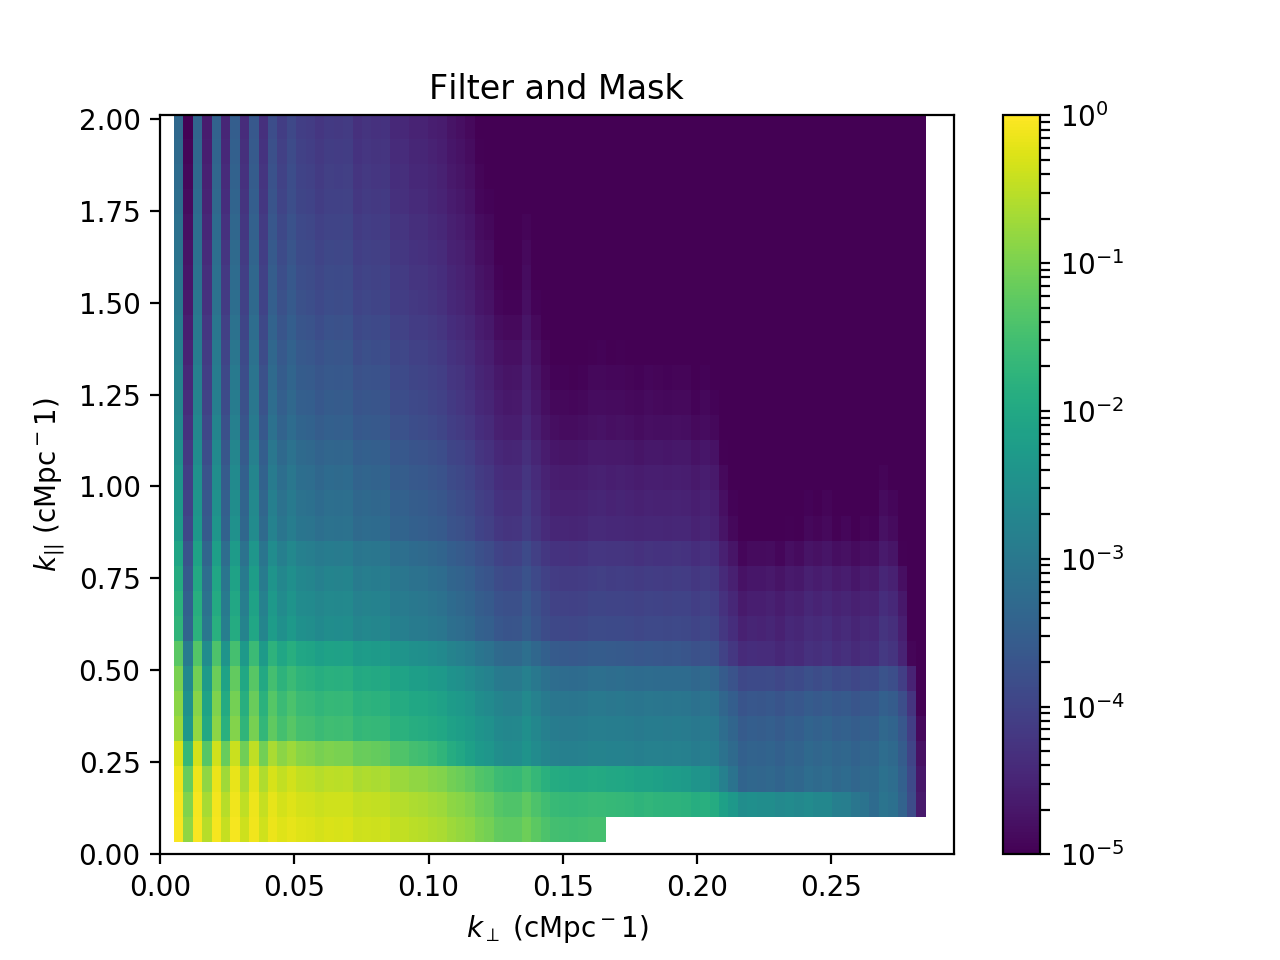

In [32]:
# plot
plt.figure()
plt.imshow(kfilters[-1][:, len(x_tiled) // 2, :].T, origin='lower', norm=LogNorm(), vmin=1e-5, vmax=1,
           extent=[kx_slices[-1].min(), kx_slices[-1].max(), kz_slices[-1].min(), kz_slices[-1].max()],
           aspect='auto')
plt.xlim([0, kx_slices[-1].max()])
plt.ylim([0, kz_slices[-1].max()])
plt.colorbar()
plt.xlabel('$k_{\perp}$ (cMpc$^-1$)')
plt.ylabel('$k_{||}$ (cMpc$^-1$)')
plt.title('Filter and Mask')
plt.savefig(plotdir + 'Filter_' + wedge_mode + '.pdf')
plt.show()

In [33]:
# Form images
filtered_images = []
for i in range(nslices):
    # Note x,y, and z axes aren't actually used here.
    filtered_images.append(np.real(calc_FT_cube(FT_slices[i] * kfilters[i], x_tiled,
                                                x_tiled, np.arange(slice_width), invert=True)[0]))
filtered_image = np.concatenate(filtered_images, axis=2)

<IPython.core.display.Javascript object>


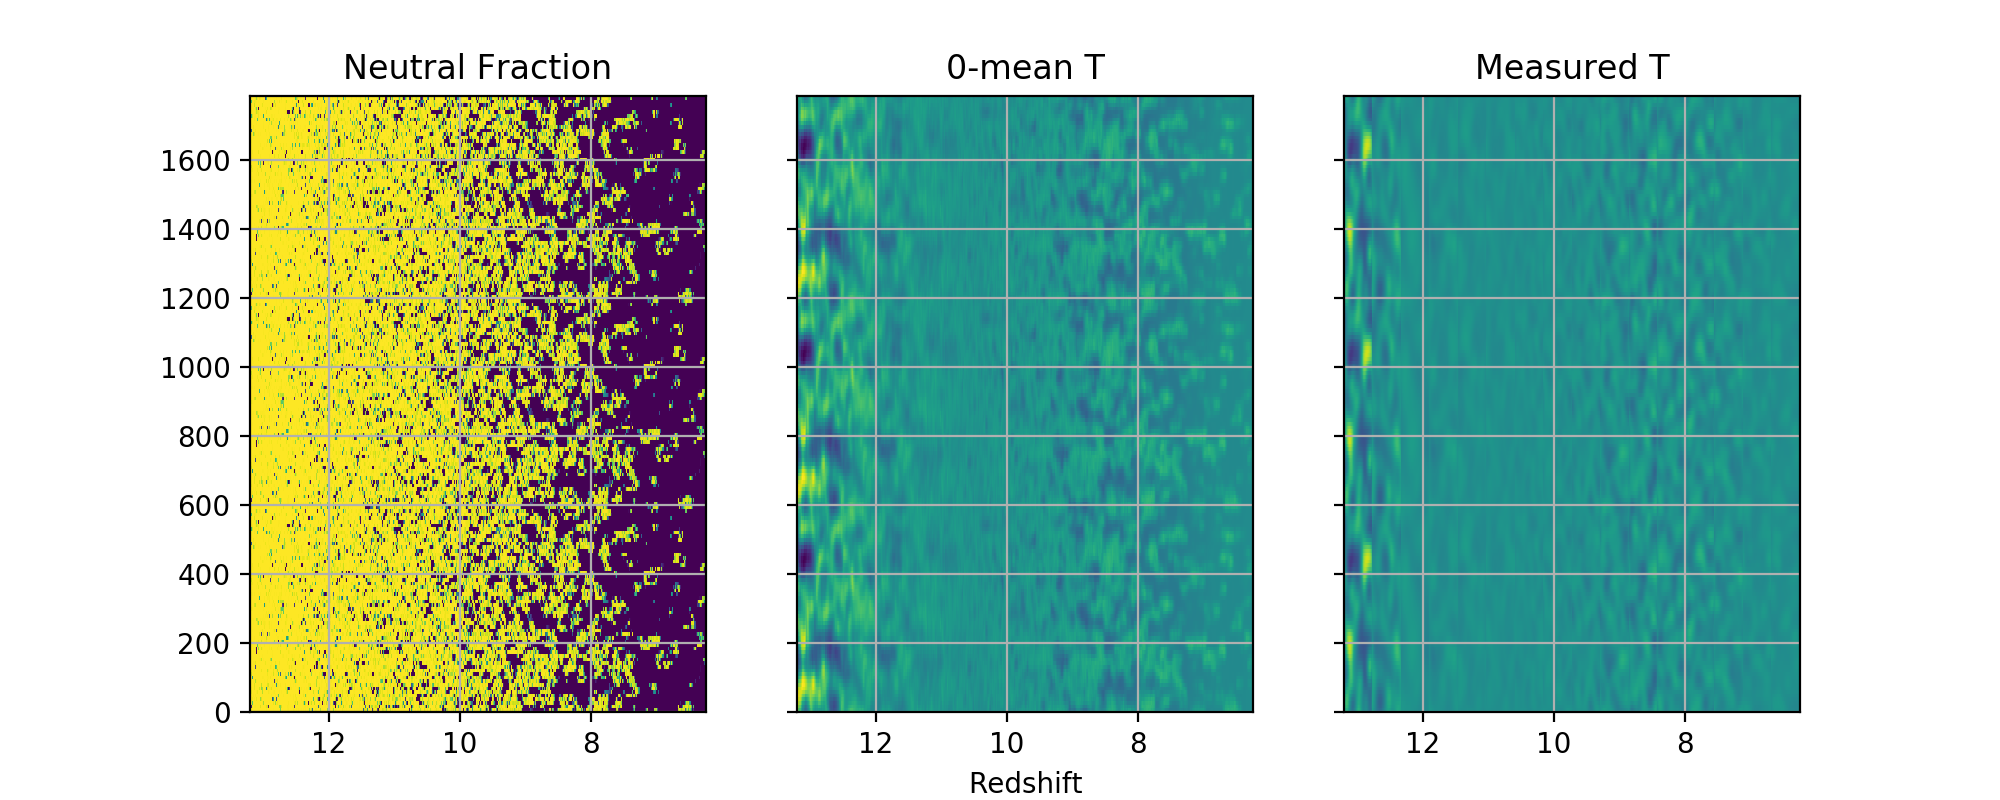

In [34]:
# plot
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10, 4))
ax[0].imshow(xH_tiled[tiled_cube.shape[0] // 2, :, :(slice_width * nslices + 1)], aspect='auto',
             extent=[bandz.max(), bandz[slice_width * nslices], x_tiled.min(), x_tiled.max()])
ax[0].grid('True')
ax[0].set_title('Neutral Fraction')
cut = tiled_cube - np.mean(tiled_cube, axis=(0, 1))
cut = cut[tiled_cube.shape[0] // 2, :, :(slice_width * nslices + 1)]
ax[1].imshow(cut, aspect='auto', extent=[bandz.max(), bandz[slice_width * nslices], x_tiled.min(), x_tiled.max()])
ax[1].grid('True')
ax[1].set_title('0-mean T')
ax[2].imshow(filtered_image[tiled_cube.shape[0] // 2, :, :], aspect='auto',
             extent=[bandz.max(), bandz[slice_width * nslices], x_tiled.min(), x_tiled.max()],
             vmin=-filtered_image.max(), vmax=filtered_image.max())
ax[2].grid('True')
ax[2].set_title('Measured T')
ax[1].set_xlabel('Redshift')
plt.savefig(plotdir + 'measured_T_' + wedge_mode + '.pdf')
plt.show()

In [35]:
# make prob curves
ithresh = 0.98
nthresh = 0.5
PDF_slices = []
nbins = 11

for i in range(nslices):
    im = filtered_images[i].copy()
    #im = xH_tiled[:, :, (i * slice_width):((i + 1) * slice_width)]
    im = np.round((nbins - 1) * (im - im.min()) / (im.max() - im.min()))
    pdf = np.zeros((nbins, 2))  # ionized and neutral
    for val in range(nbins):
        ind = np.where(im == val)
        if len(ind[0]) == 0:
            pdf[val, :] = [np.nan, np.nan]
        else:
            subcube = xH_cone[(xmap[ind[0]], xmap[ind[1]], ind[2] + i * slice_width)]
            pdf[val, 0] = float(len(np.where(subcube < (1 - ithresh))[0])) / len(ind[0])
            pdf[val, 1] = float(len(np.where(subcube > nthresh)[0])) / len(ind[0])
    PDF_slices.append(pdf)
pdf_axis = np.linspace(-0.5, 0.5, nbins)

<IPython.core.display.Javascript object>


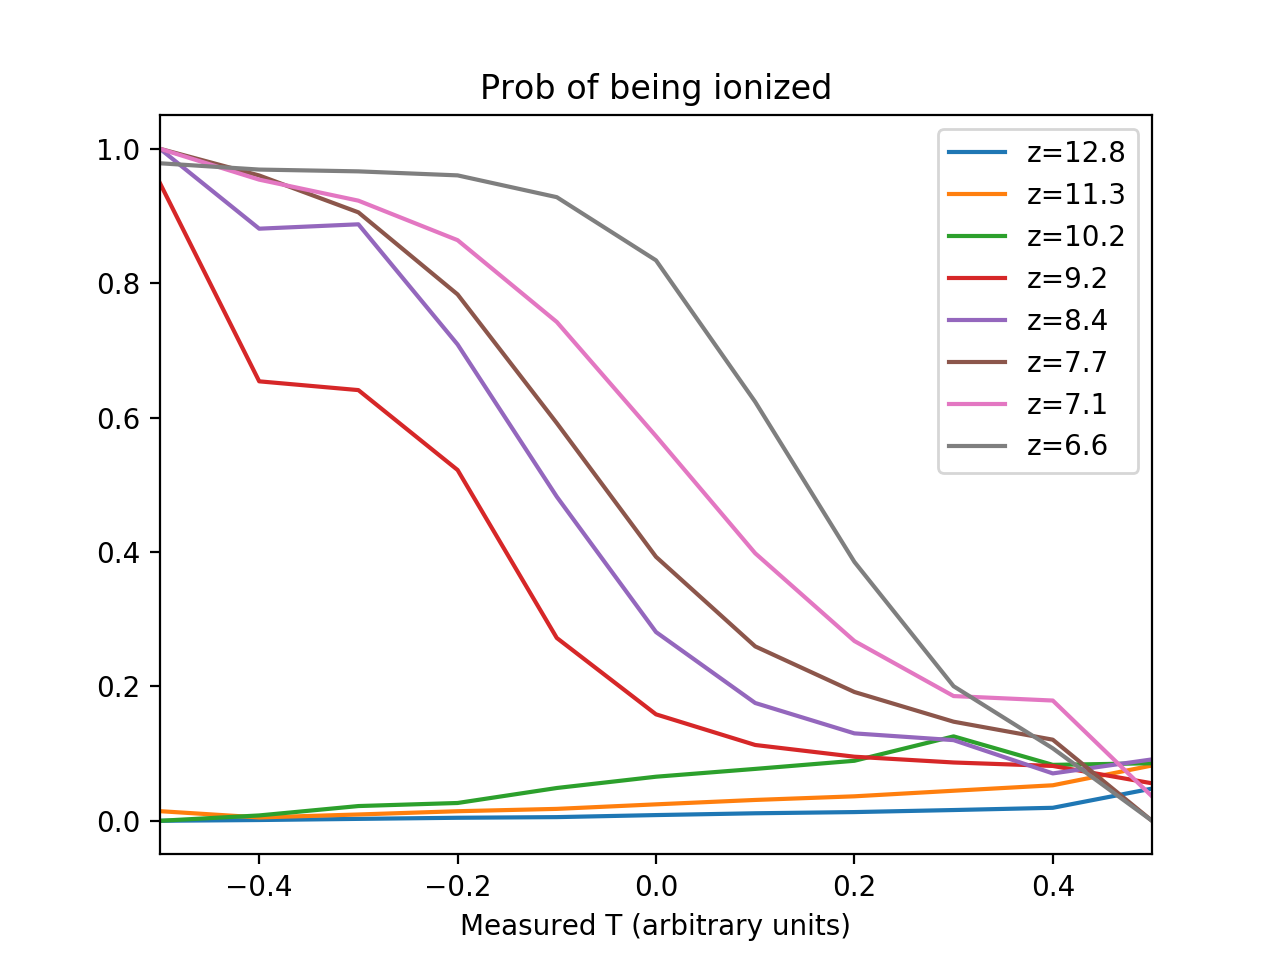

In [36]:
# plot
plt.figure()
for i in range(0, nslices, 2):
    plt.plot(pdf_axis, PDF_slices[i][:, 0], label="z={:.1f}".format(bandz[int((i + 0.5) * slice_width)]))
plt.legend()
plt.title('Prob of being ionized')
plt.xlim([-0.5, 0.5])
plt.xlabel('Measured T (arbitrary units)')
plt.savefig(plotdir + 'prob_xi_vs_z_' + wedge_mode + '.pdf')
plt.show()

<IPython.core.display.Javascript object>


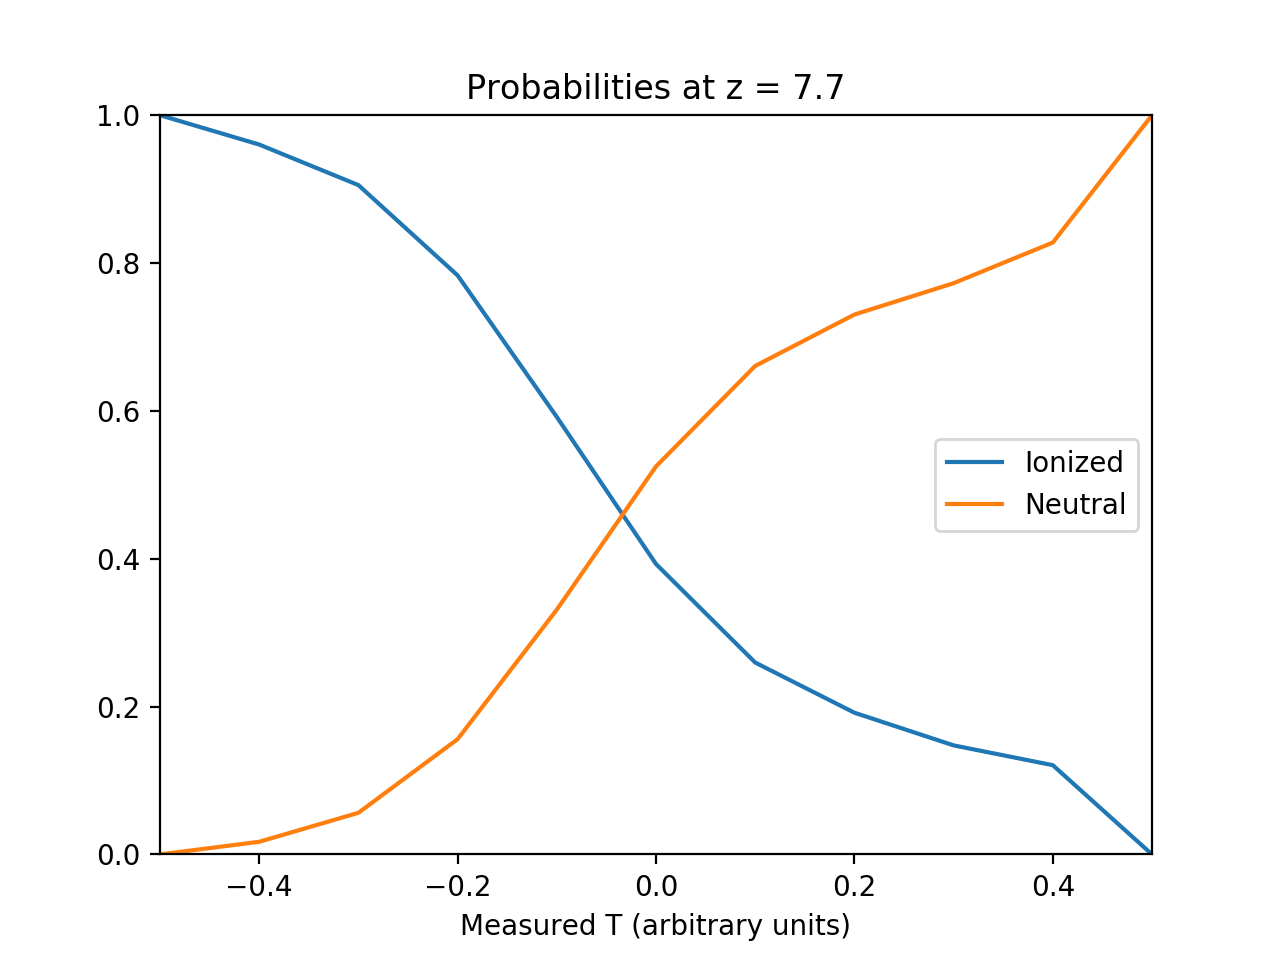

In [37]:
# plot
zi = 10
plt.figure()
plt.plot(pdf_axis, PDF_slices[zi][:, 0], label='Ionized')
plt.plot(pdf_axis, PDF_slices[zi][:, 1], label='Neutral')
plt.xlim([-0.5, 0.5])
plt.ylim([0, 1])
plt.title('Probabilities at z = {:.1f}'.format(bandz[int(slice_width * (zi + 0.5))]))
plt.xlabel('Measured T (arbitrary units)')
plt.legend()
plt.savefig(plotdir + 'prob_i_v_n_' + wedge_mode + '.pdf')
plt.show()

In [38]:
# Make probability image
ind = np.argmin(np.abs(bandz - z0))  # Make sure I haven't reused it
slicei = int(np.floor(ind / slice_width))
slice_ind = int(ind % slice_width)

im = filtered_images[slicei]
im = (nbins - 1) * (im - im.min()) / (im.max() - im.min())
im = im[:, :, slice_ind]
f = interp1d(np.arange(nbins), PDF_slices[slicei][:, 0], kind='cubic')
xii_image = f(im)

<IPython.core.display.Javascript object>


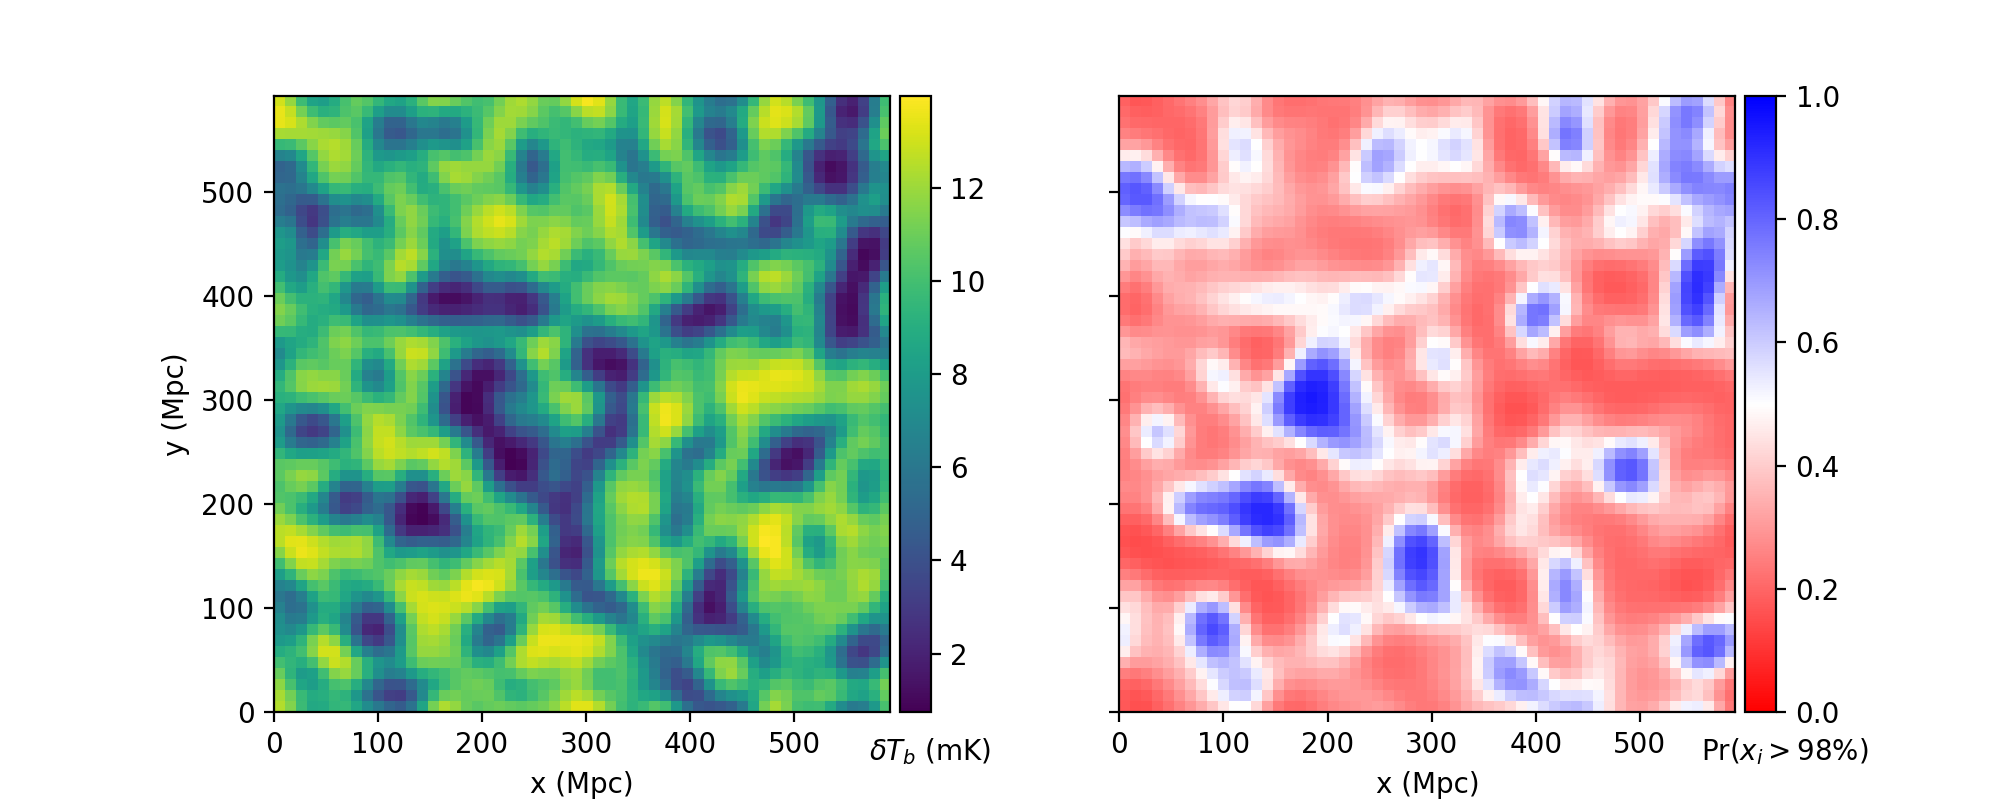

In [39]:
# plot
f, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
ind_use = downselect_cube.shape[0] - 1
ext = [x_tiled[0], x_tiled[ind_use], x_tiled[0], x_tiled[ind_use]]
im = ax[0].imshow(tiled_cube[0:ind_use, 0:ind_use, ind], extent=ext, aspect='equal')
# im.set_clim([-0.6 * tiled_cube[:, :, ind].max(), 0.6 * tiled_cube[:, :, ind].max()])
ax[0].set_xlabel('x (Mpc)')
ax[0].set_ylabel('y (Mpc)')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('$\delta T_b$ (mK)', labelpad=-20, y=-0.04, rotation=0)

im = ax[1].imshow(xii_image[0:ind_use, 0:ind_use], extent=ext, aspect='equal', cmap=plt.get_cmap('bwr_r'))
im.set_clim([0, 1])
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(im, cax=cax)
cb.set_label('Pr($x_i > 98\%$)', labelpad=-20, y=-0.04, rotation=0)
ax[1].set_xlabel('x (Mpc)')
plt.show()
plt.savefig(plotdir + 'prob_perp_im_' + wedge_mode + '.pdf')

In [40]:
# Neutral fraction history from measured
z_width = 1
buffer_width = 3  # Number of bins to include in grouping

im = filtered_images[slicei].copy()
im = np.round((nbins - 1) * (im - im.min()) / (im.max() - im.min()))
ind_xHI = np.where(im[:, :, slice_ind] >= (nbins - 1 - buffer_width))
ind_xHI = (xmap[ind_xHI[0]], xmap[ind_xHI[1]])
xH_neutral_m, xH_neutral_conf_m = calc_xH_v_z(xH_cube, ind=ind_xHI, p=0.68)
ind_xHII = np.where(im[:, :, slice_ind] <= buffer_width)
ind_xHII = (xmap[ind_xHII[0]], xmap[ind_xHII[1]])
xH_ionized_m, xH_ionized_conf_m = calc_xH_v_z(xH_cube, ind=ind_xHII, p=0.68)

<IPython.core.display.Javascript object>


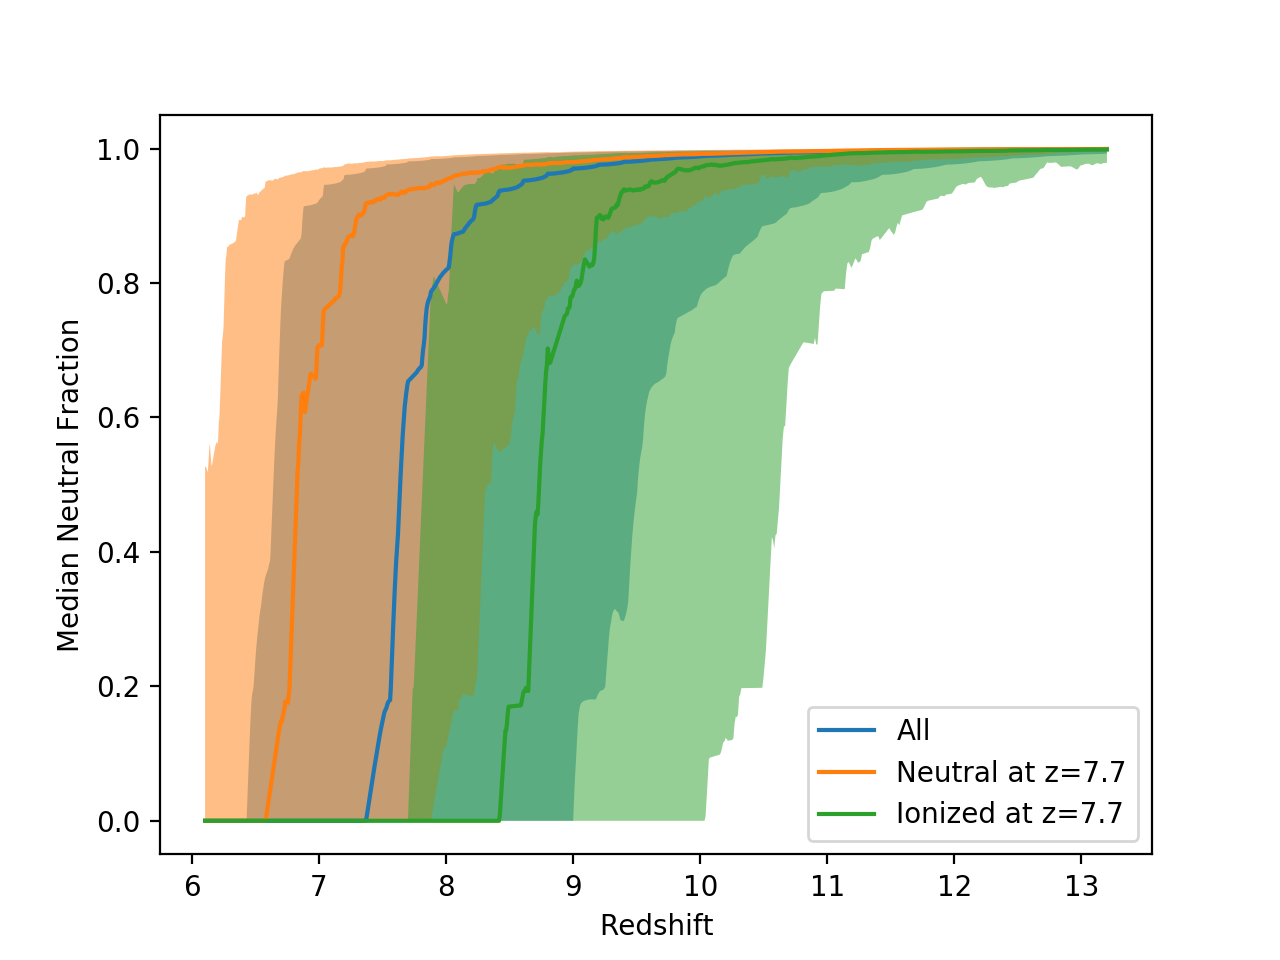

In [41]:
# Plot
plt.figure()
plt.plot(bandz, xH_all, label='All')
plt.fill_between(bandz, xH_all_conf[0, :], xH_all_conf[1, :], alpha=0.5)
plt.plot(bandz, xH_neutral_m, label='Neutral at z=' + str(z0))
plt.fill_between(bandz, xH_neutral_conf_m[0, :], xH_neutral_conf_m[1, :], alpha=0.5)
plt.plot(bandz, xH_ionized_m, label='Ionized at z=' + str(z0))
plt.fill_between(bandz, xH_ionized_conf_m[0, :], xH_ionized_conf_m[1, :], alpha=0.5)
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Median Neutral Fraction')
plt.savefig(plotdir + 'measured_nf_groups' + wedge_mode + '.pdf')
plt.show()

In [ ]:
#### Make plots for HERA msip

In [143]:
# Set up band
zmin = 7.5
zmax = 8.5
ind0 = np.argmin(np.abs(7.5 - bandz))
ind1 = np.argmin(np.abs(8.5 - bandz))
zaxis_h = zaxis[ind0:ind1:-1]
raw_cube_h = raw_cube[:, :, ind1:ind0]
tiled_cube_h = tiled_cube[:, :, ind1:ind0]
bandz_h = bandz[ind1:ind0]
band_h = band[ind1:ind0]
z0_h = bandz_h.mean()

display(HTML("<style>.container { width:100% !important; }</style>"))

In [88]:
# FT cube, get raw PS
raw_PS, raw_k = calc_PS_1d(raw_cube_h, xaxis, yaxis, zaxis_h, k_bin=10)
tiled_FT, tiled_kx, tiled_ky, tiled_kz = calc_FT_cube(tiled_cube_h, x_tiled, x_tiled, zaxis_h)

In [89]:
# PS interp
kx_mat, ky_mat, kz_mat = np.meshgrid(tiled_kx, tiled_ky, tiled_kz, indexing='ij')
kperp_mat = np.sqrt(kx_mat**2 + ky_mat**2)
kmat = np.sqrt(kx_mat**2 + ky_mat**2 + kz_mat**2)
f = interp1d(raw_k, raw_PS)
PS_interp = f(kmat)

In [90]:
# Noise estimate
ndays = 225.
time_length = (fov / 2) / (2 * np.pi) * 24. * 3600.  # seconds
dt = 1. * 60.  # seconds
time_range = np.arange(-time_length / 2, time_length / 2, dt)
# Some geo to trim down code later
latitude = -0.53619181  # rad
dec = latitude  # zen drift
sdec = np.sin(dec)
cdec = np.cos(dec)
slat = np.sin(latitude)
clat = np.cos(latitude)

redshift = bandz_h.mean()
B = band_h[-1] - band_h[0] * 1e6  # Hz
f0 = np.mean(band_h)  # MHz
lambdas = const.c.to('m/s').value / (band_h * 1e6)  # m
lambda0 = lambdas.mean()
D = zaxis_h.mean()  # Mpc
deltaD = zaxis_h[0] - zaxis_h[-1]  # Mpc
Aeff = 93.  # m^2 (Neben et al 2016)
Tsys = (180. * (180. / f0)**2.55 + 100.) * 1e3  # mK
factor = Tsys**2 * (D**2 * lambda0**2 / Aeff) * (deltaD / B)  # Beardsley et al 2013 (eq 2)

count_mat = np.zeros(tiled_FT.shape[0:2])
b2k = 2 * np.pi / zaxis_h / lambdas
dkx = np.mean(np.diff(tiled_kx))
dky = np.mean(np.diff(tiled_ky))
for t in time_range:
    theta = t * np.pi / (12. * 3600.)
    # do rotation
    u_m = bls[:, 0] * np.cos(theta) - bls[:, 1] * slat * np.sin(theta)
    v_m = bls[:, 0] * sdec * np.sin(theta) + bls[:, 1] * (sdec * np.cos(theta) * slat + cdec * clat)
    for fi in range(slice_width):
        # scale u
        u = u_m * b2k[fi]
        v = v_m * b2k[fi]
        # bin
        ind = (map(int, np.round(u / dkx) - mat.shape[0] // 2),
               map(int, np.round(v / dky) - mat.shape[1] // 2))
        count_mat[ind] += bl_counts * dt
temp = np.zeros_like(count_mat)
temp = np.divide(factor, count_mat * ndays, where=count_mat > .5 * dt)
noise_mat = np.where(count_mat > .5 * dt, temp, np.inf)
noise_mat *= len(band)  # should be average over freq, not sum

In [91]:
# Get noise
jacobian = np.abs(np.mean(np.diff(zaxis_h)) * np.mean(np.diff(x_tiled))**2.)
noise = get_noise(tiled_FT, noise_mat, jacobian, seed=2)

In [92]:
# Apply filter and FG mask
kfilters = []
wedge_slopes = [np.pi / 2., fov / 2.]

for i in range(2):
    kfilters.append(PS_interp / (PS_interp + noise_mat.reshape(noise_mat.shape + (1,))))
    wedge_slope = (wedge_slopes[i] * cosmo.comoving_distance(z0_h).value /
                   cosmo.hubble_distance.value * cosmo.efunc(z0_h) / (1 + z0_h))
    kfilters[i][np.abs(kz_mat) < wedge_slope * kperp_mat] = 0
    kfilters[i][kperp_mat <= kperp_buffer] = 0
    kfilters[i][np.abs(kz_mat) <= kz_buffer] = 0

In [93]:
# Form images
# Note axes passed here aren't actually used.
filtered_images = []
filtered_noises = []
for i in range(2):
    filtered_images.append(np.real(calc_FT_cube(tiled_FT * kfilters[i], x_tiled,
                                                x_tiled, zaxis_h, invert=True)[0]))
    filtered_noises.append(np.real(calc_FT_cube(noise * kfilters[i], x_tiled,
                                                x_tiled, zaxis_h, invert=True)[0]))

<IPython.core.display.Javascript object>


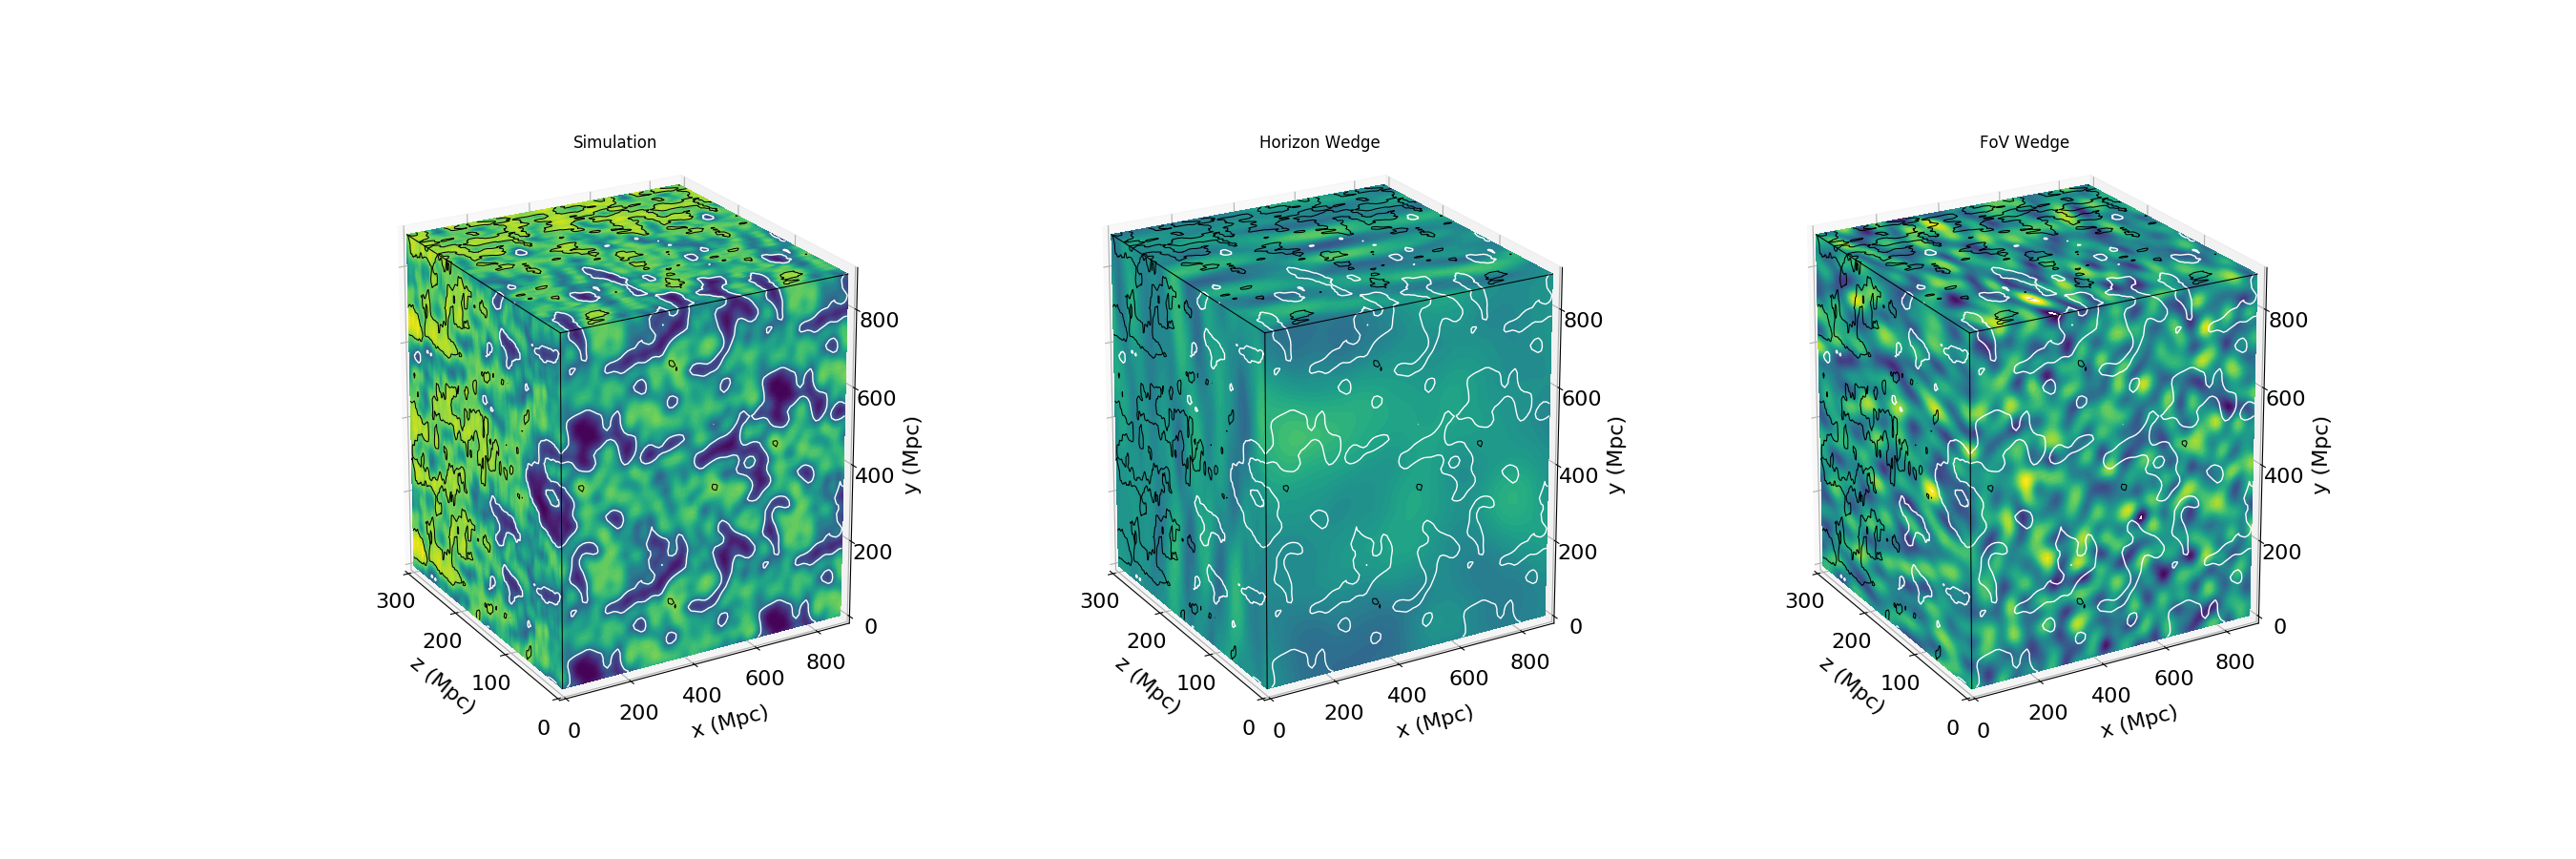

In [167]:
# 3D cube - Set of 3
vmax = [(tiled_cube_h).max()]
vmax += [0.7 * (f + n).max() for f, n in zip(filtered_images, filtered_noises)]
vmax[1] /= 0.5  # Compress scale for horizon to illustrate washing out
ncountours = 50
contour_alpha = 1 #0.75
contour_levels = [0.3 * vmax[0], 0.8 * vmax[0]]
# contour_colors = ['black', 'white']
contour_colors = ['white', 'black']
contour_linewidths = [1.0, .75]
inds_perp = filtered_images[0].shape[0] / 2
inds_par = filtered_images[0].shape[2]

X, Y, Z = np.meshgrid(zaxis_h[:inds_par], x_tiled[:inds_perp], x_tiled[:inds_perp], indexing='ij')
X -= X.min()
ims = [(i[:inds_perp, :inds_perp, :inds_par] + n[:inds_perp, :inds_perp, :inds_par]).swapaxes(0, 2)
       for i, n in zip(filtered_images, filtered_noises)]
cim = tiled_cube_h[:inds_perp, :inds_perp, :inds_par].swapaxes(0, 2)

nplots = 3
fig = plt.figure(figsize=(9 * nplots, 9))

axs = []

## Reference cube
axs.append(fig.add_subplot(1, nplots, 1, projection='3d'))
axs[0].view_init(20, -30)
axs[0].contourf(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.max(),
                levels=np.linspace(0, vmax[0], ncountours))
axs[0].contourf(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                levels=np.linspace(0, vmax[0], ncountours))
axs[0].contourf(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                levels=np.linspace(0, vmax[0], ncountours))
axs[0].contour(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.max(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
axs[0].contour(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
axs[0].contour(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
               colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)

for i in range(nplots - 1):
    axs.append(fig.add_subplot(1, nplots, i + 2, projection='3d'))
    axs[i + 1].view_init(20, -30)
    axs[i + 1].contourf(ims[i][-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.max(),
                    levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours))
    axs[i + 1].contourf(X[:, 0, :], ims[i][:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                    levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours))
    axs[i + 1].contourf(X[:, :, -1], Y[:, :, -1], ims[i][:, :, -1], zdir='z', offset=Z.max(),
                    levels=np.linspace(-vmax[i + 1], vmax[i + 1], ncountours), zorder=0)

    axs[i + 1].contour(cim[-1, :, :], Y[-1, :, :], Z[-1, :, :], zdir='x', offset=X.max(),
                   colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    axs[i + 1].contour(X[:, 0, :], cim[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(),
                   colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)
    axs[i + 1].contour(X[:, :, -1], Y[:, :, -1], cim[:, :, -1], zdir='z', offset=Z.max(),
                   colors=contour_colors, alpha=contour_alpha, levels=contour_levels, linewidths=contour_linewidths)


# Touch up axes
titles = ['Simulation', 'Horizon Wedge', 'FoV Wedge']
for i in range(nplots):
    axs[i].plot([X.max(), X.max()], [Y.min(), Y.min()], [Z.min(), Z.max()], color='k', zorder=300, linewidth=0.75)
    axs[i].plot([X.min(), X.max()], [Y.min(), Y.min()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.75)
    axs[i].plot([X.max(), X.max()], [Y.min(), Y.max()], [Z.max(), Z.max()], color='k', zorder=300, linewidth=0.75)

    axs[i].set_xlim3d((zaxis_h.max() - zaxis_h.min()), 0)
    axs[i].set_xlim3d(0, (zaxis_h.max() - zaxis_h.min()))
    axs[i].xaxis.set_ticks(np.arange(0, 301, 100))
    axs[i].xaxis.set_ticklabels(np.arange(300, -1, -100), fontsize=16)
    axs[i].set_xlabel('z (Mpc)', fontsize=16, labelpad=10)
    axs[i].set_ylim3d(Y.min(), Y.max())
    axs[i].yaxis.set_ticks(np.arange(0, 1000, 200))
    axs[i].yaxis.set_ticklabels(np.arange(0, 1000, 200), fontsize=16)
    axs[i].set_ylabel('x (Mpc)', fontsize=16, labelpad=10)
    axs[i].set_zlim3d(Z.min(), Z.max())
    axs[i].zaxis.set_ticks(np.arange(0, 1000, 200))
    axs[i].zaxis.set_ticklabels(np.arange(0, 1000, 200), fontsize=16)
    axs[i].set_zlabel('y (Mpc)', fontsize=16, labelpad=10)
    axs[i].set_title(titles[i])

# plt.savefig(plotdir + 'Images3D_' + str(nplots) + 'plots_' + run_name + '_' + str(ndays) + '_days.pdf')


In [140]:
# Get probability curves
PDF_curves = []
ithresh = 0.98
nthresh = 0.5
nbins_meas = 13
nbins_raw = 30

X, Y = np.meshgrid(xmap, xmap)
ref_cube = xH_cone[Y, X, ind1:ind0]

for i in range(2):
    im = filtered_images[i].copy() + filtered_noises[i].copy()
    im = np.round((nbins_meas - 1) * (im - im.min()) / (im.max() - im.min()))
    pdf = np.zeros((nbins_meas, 2))  # ionized and neutral
    for val in range(nbins_meas):
        ind = np.where(im == val)
        if len(ind[0]) == 0:
            pdf[val, :] = [np.nan, np.nan]
        else:
            subcube = ref_cube[(ind[0], ind[1], ind[2])]
            pdf[val, 0] = float(len(np.where(subcube < (1 - ithresh))[0])) / len(ind[0])
            pdf[val, 1] = float(len(np.where(subcube > nthresh)[0])) / len(ind[0])
    PDF_curves.append(pdf)
pdf_axis = np.linspace(-0.5, 0.5, nbins_meas)

<IPython.core.display.Javascript object>


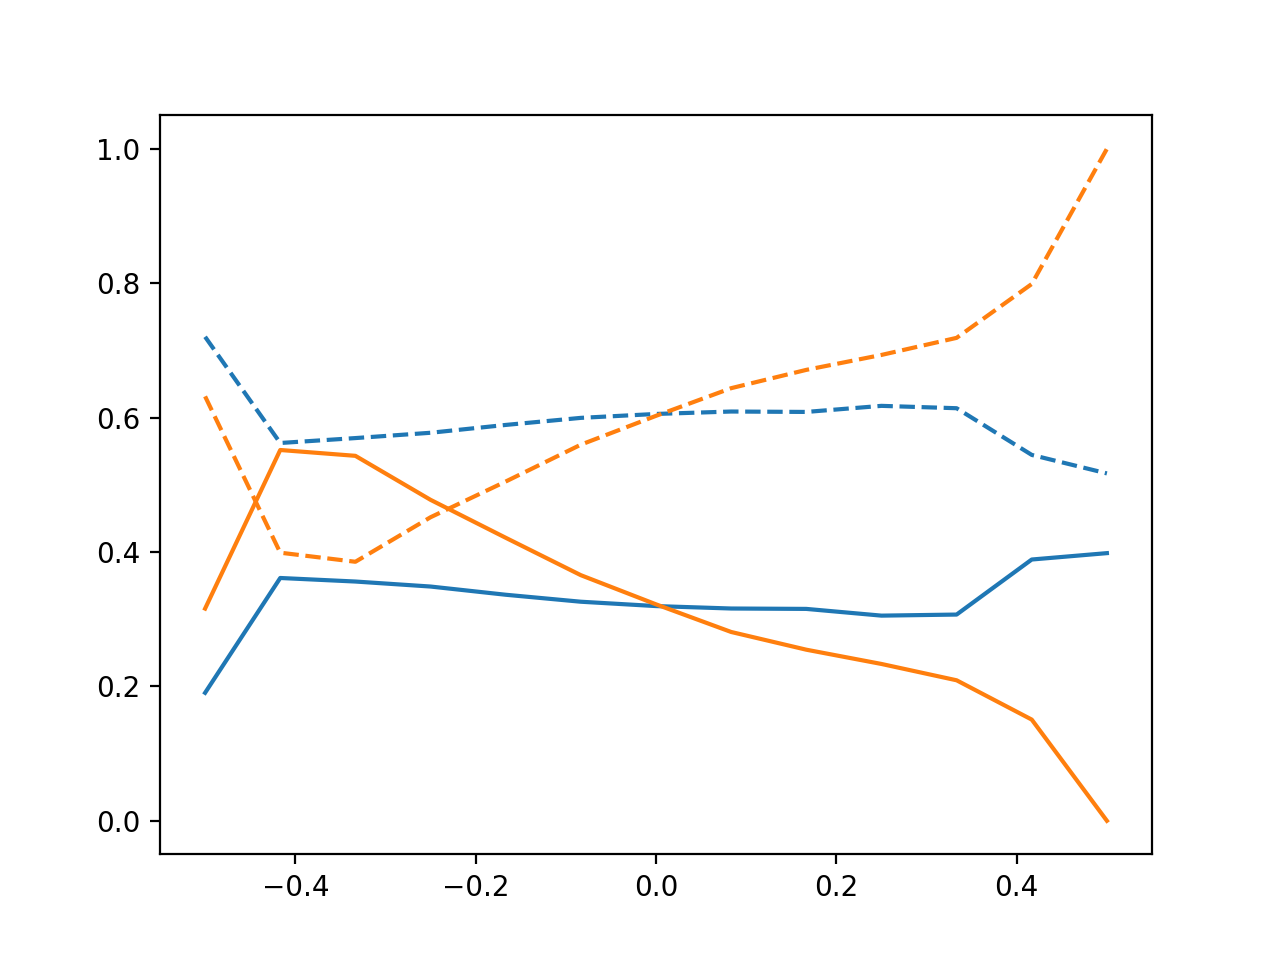

IndexError: list index out of range

In [141]:
# Plot probability curves
plt.figure()
for i in range(3):
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(pdf_axis, PDF_curves[i][:, 0], color=color, label=titles[i + 1])
    plt.plot(pdf_axis, PDF_curves[i][:, 1], '--', color=color)
plt.xlabel('Measured T (Arbitrary Units)')
plt.ylabel('Probability')
plt.legend()